<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Useful-Functions" data-toc-modified-id="Useful-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Useful Functions</a></span></li><li><span><a href="#Initial-Classifier-Using-The-IMAC-Dataset" data-toc-modified-id="Initial-Classifier-Using-The-IMAC-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initial Classifier Using The IMAC Dataset</a></span></li><li><span><a href="#Process-Last.fm-Database-for-Emotional-Tags" data-toc-modified-id="Process-Last.fm-Database-for-Emotional-Tags-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Process Last.fm Database for Emotional Tags</a></span></li><li><span><a href="#Query-Spotify-for-Audio-Features-(Full-Set)" data-toc-modified-id="Query-Spotify-for-Audio-Features-(Full-Set)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Query Spotify for Audio Features (Full Set)</a></span></li><li><span><a href="#Building-a-Classifier-for-Full-Training-Set" data-toc-modified-id="Building-a-Classifier-for-Full-Training-Set-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Building a Classifier for Full Training Set</a></span></li><li><span><a href="#Query-Genius-API-for-Song-Lyrics-(Full-Training-Set)" data-toc-modified-id="Query-Genius-API-for-Song-Lyrics-(Full-Training-Set)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Query Genius API for Song Lyrics (Full Training Set)</a></span></li><li><span><a href="#Attempt:-Build-Classifier-Model-Using-Full-Training-Set-(Lyrics-Only)" data-toc-modified-id="Attempt:-Build-Classifier-Model-Using-Full-Training-Set-(Lyrics-Only)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Attempt: Build Classifier Model Using Full Training Set (Lyrics Only)</a></span></li><li><span><a href="#Build-Classifier-Model-Using-Lyrical-Training-Set-(Lyrical-Sentiment-and-Spotify-Features)" data-toc-modified-id="Build-Classifier-Model-Using-Lyrical-Training-Set-(Lyrical-Sentiment-and-Spotify-Features)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Build Classifier Model Using Lyrical Training Set (Lyrical Sentiment and Spotify Features)</a></span></li><li><span><a href="#Build-Classifier-Model-Using-Instrumental-Training-Set-(Spotify-Features-Only)" data-toc-modified-id="Build-Classifier-Model-Using-Instrumental-Training-Set-(Spotify-Features-Only)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Build Classifier Model Using Instrumental Training Set (Spotify Features Only)</a></span></li></ul></div>

In [358]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import urllib.request
import requests
from bs4 import BeautifulSoup
import time
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import sklearn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from textblob import TextBlob
import os 
import sys 
import sqlite3
import pickle
from joblib import dump
import lyricsgenius
from langdetect import detect
from fuzzywuzzy import fuzz
%matplotlib inline

In [128]:
# Set seaborn styles
sns.set_style("whitegrid")
sns.set_context("notebook")

In [5]:
sklearn.__version__

'0.22.1'

In [4]:
sys.executable

'/Users/jecutter/opt/anaconda3/bin/python3'

# Useful Functions

In [201]:
def split_by_emotion(features, labels):
    x_train1, x_test1, y_train1, y_test1 = train_test_split(features[labels.overall_emotion=='happy'], labels[labels.overall_emotion=='happy'], test_size=0.2, random_state=1)
    x_train2, x_test2, y_train2, y_test2 = train_test_split(features[labels.overall_emotion=='calm'], labels[labels.overall_emotion=='calm'], test_size=0.2, random_state=2)
    x_train3, x_test3, y_train3, y_test3 = train_test_split(features[labels.overall_emotion=='sad'], labels[labels.overall_emotion=='sad'], test_size=0.2, random_state=3)
    x_train4, x_test4, y_train4, y_test4 = train_test_split(features[labels.overall_emotion=='angry'], labels[labels.overall_emotion=='angry'], test_size=0.2, random_state=4)
    
    x_train = pd.concat([x_train1, x_train2, x_train3, x_train4])
    x_test = pd.concat([x_test1, x_test2, x_test3, x_test4])
    y_train = pd.concat([y_train1, y_train2, y_train3, y_train4])
    y_test = pd.concat([y_test1, y_test2, y_test3, y_test4])
    
    return x_train, x_test, y_train, y_test
    

In [164]:
# Convert emotional score labels on songs into
# an overall positive, neutral, or negative emotion
# NOTE: only used if using the original emotional scores of the IMAC dataset (DEPRECATED)
def parse_song_emotion(df):
    # Label emotion based on the emotion score
    # (positive, neutral, negative)
    scores = df['split_score']

    emotion = []
    for i,song in enumerate(scores.values):
        if np.max(song) == np.min(song):
            emotion.append('NA')
        else:
            if np.argmax(song) == 0:
                emotion.append('happy')
            elif np.argmax(song) == 1 or song[0] == song[2]:
                emotion.append('neutral')
            elif np.argmax(song) == 2:
                emotion.append('sad')

    df['overall_emotion'] = emotion


In [381]:
# Use Spotify API (through Spotipy) to query for audio features
# of all the songs in the training dataset
def fetch_spotify_features(df):
    # Fetch audo features for songs using Spotify API (through Spotipy)
    danceability = []
    energy = []
    key = []
    loudness = []
    mode = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    duration_ms = []
    time_signature = []

    #track_name = "Welcome to the Pleasuredome"
    #artist_name = "Frankie Goes To Hollywood"
    
    # Give Spotify credentials
    #sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())
    token = util.oauth2.SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
    cache_token = token.get_access_token()
    sp = spotipy.Spotify(cache_token)

    counter = 1
    for track_name, artist_name in df[['title', 'artist']].values:
        try:
            result = sp.search(q='track:' + track_name.lower() + ' artist:' + artist_name.lower())
            track_id = result['tracks']['items'][0]['id']
            features = sp.audio_features(tracks=[track_id])
            
            danceability.append(features[0]['danceability'])
            energy.append(features[0]['energy'])
            key.append(features[0]['key'])
            loudness.append(features[0]['loudness'])
            mode.append(features[0]['mode'])
            speechiness.append(features[0]['speechiness'])
            acousticness.append(features[0]['acousticness'])
            instrumentalness.append(features[0]['instrumentalness'])
            liveness.append(features[0]['liveness'])
            valence.append(features[0]['valence'])
            tempo.append(features[0]['tempo'])
            duration_ms.append(features[0]['duration_ms'])
            time_signature.append(features[0]['time_signature'])
        except:
            danceability.append('NA')
            energy.append('NA')
            key.append('NA')
            loudness.append('NA')
            mode.append('NA')
            speechiness.append('NA')
            acousticness.append('NA')
            instrumentalness.append('NA')
            liveness.append('NA')
            valence.append('NA')
            tempo.append('NA')
            duration_ms.append('NA')
            time_signature.append('NA')

        if counter % 50 == 0:
            print('Sleeping on counter =', counter, 'for 5 seconds...')
            if counter % 200 == 0:
                print(features)
            time.sleep(5)
        counter += 1

        #if counter == 50:
        #    break

    #print(danceability, energy, time_signature)

    # Assign the Spotify features in the dataframe
    df['danceability'] = danceability
    df['energy'] = energy
    df['key'] = key
    df['loudness'] = loudness
    df['mode'] = mode
    df['speechiness'] = speechiness
    df['acousticness'] = acousticness
    df['instrumentalness'] = instrumentalness
    df['liveness'] = liveness
    df['valence'] = valence
    df['tempo'] = tempo
    df['duration_ms'] = duration_ms
    df['time_signature'] = time_signature


In [253]:
# Process emotional tags directly from the Last.fm database
def process_lastfm_dbs():
    # Read in the emotional tags used by IMAC people
    #happy = np.genfromtxt('Data/happy.txt', dtype=str, delimiter='\n')
    #joyous = np.genfromtxt('Data/joyous.txt', dtype=str, delimiter='\n')
    ##energetic = np.genfromtxt('Data/energetic.txt', dtype=str, delimiter='\n')
    #soothing = np.genfromtxt('Data/soothing.txt', dtype=str, delimiter='\n')
    #relax = np.genfromtxt('Data/relax.txt', dtype=str, delimiter='\n')
    #calm = np.genfromtxt('Data/calm.txt', dtype=str, delimiter='\n')
    #sad = np.genfromtxt('Data/sad.txt', dtype=str, delimiter='\n')

    # Set the emotional words we will search for in user tags
    happy = ['happy', 'happily', 'happiness', 'joy', 'joyous', 'joyful', 'fun', 'cheerful', 'jovial']
    calm = ['calm', 'calmed', 'calming', 'calms', 'soothe', 'soothes', 'soothing', 'relax', 'relaxed', 'relaxing', 'relaxes', 'quiet', 'quieting', 'peace', 'peaceful', 'chill', 'chillax', 'tranquil', 'tranquility']
    sad = ['sad', 'sadness', 'sadly', 'saddening', 'unhappy', 'unhappiness', 'sorrow', 'sorrowful', 'depressive', 'depressed', 'depression', 'depressing', 'despair', 'gloomy']
    angry = ['angry', 'anger', 'angrily', 'mad', 'madness', 'rage', 'enraged', 'violent', 'violence', 'aggressive', 'frustrated', 'frustration']

    # Open Last.fm database file with tag data for all songs
    dbfile = './Data/lastfm_tags.db'
    conn = sqlite3.connect(dbfile)
    # Open Last.fm database file with track metadata (for artists/titles)
    tfile = './Data/track_metadata.db'
    conn2 = sqlite3.connect(tfile)

    # Fetch tags from tag database
    #sql = "SELECT tag FROM tags" 
    #res = conn.execute(sql) 
    #data = res.fetchall() 

    #tags = [item[0] for item in data]
    #h_tags = [item for item in data if any(re.search(rf'\b{key}\b', item[0].lower()) for key in happy) and not any(re.search(rf'\b{key}\b', item[0].lower()) for key in calm+sad+angry)]
    #c_tags = [item for item in data if any(re.search(rf'\b{key}\b', item[0].lower()) for key in calm) and not any(re.search(rf'\b{key}\b', item[0].lower()) for key in happy+sad+angry)]
    #s_tags = [item for item in data if any(re.search(rf'\b{key}\b', item[0].lower()) for key in sad) and not any(re.search(rf'\b{key}\b', item[0].lower()) for key in happy+calm+angry)]
    #a_tags = [item for item in data if any(re.search(rf'\b{key}\b', item[0].lower()) for key in angry) and not any(re.search(rf'\b{key}\b', item[0].lower()) for key in happy+calm+sad)]
    #print(len(h_tags), len(c_tags), len(s_tags), len(a_tags))

    # Fetch track IDs from tag database
    sql = "SELECT tid FROM tids"
    res = conn.execute(sql)
    data = res.fetchall()
    tids = [item[0] for item in data]

    e_tids = []
    e_artists = []
    e_titles = []

    h_tags = []
    c_tags = []
    s_tags = []
    a_tags = []
    num_h_tags = []
    num_c_tags = []
    num_s_tags = []
    num_a_tags = []

    for i, tid in enumerate(tids):
        if i%5000 == 0:
            print('Working on track', i, '...')

        # Grab tags for each track ID
        sql = "SELECT tags.tag, tid_tag.val FROM tid_tag, tids, tags WHERE tags.ROWID=tid_tag.tag AND tid_tag.tid=tids.ROWID and tids.tid='%s'" % tid
        res = conn.execute(sql)
        track_tags = res.fetchall()

        # Check for tags matching emotional words
        h = [item[0].lower() for item in track_tags if any(re.search(rf'\b{key}\b', item[0].lower()) for key in happy) and not any(re.search(rf'\b{key}\b', item[0].lower()) for key in calm+sad+angry)]
        c = [item[0].lower() for item in track_tags if any(re.search(rf'\b{key}\b', item[0].lower()) for key in calm) and not any(re.search(rf'\b{key}\b', item[0].lower()) for key in happy+sad+angry)]
        s = [item[0].lower() for item in track_tags if any(re.search(rf'\b{key}\b', item[0].lower()) for key in sad) and not any(re.search(rf'\b{key}\b', item[0].lower()) for key in happy+calm+angry)]
        a = [item[0].lower() for item in track_tags if any(re.search(rf'\b{key}\b', item[0].lower()) for key in angry) and not any(re.search(rf'\b{key}\b', item[0].lower()) for key in happy+calm+sad)]

        # Continue if no emotional tags
        if len(h) == 0 and len(c) == 0 and len(s) == 0 and len(a) == 0:
            continue

        e_tids.append(tid)
        q = f"SELECT artist_name, title FROM songs WHERE track_id='{tid}'" 
        res2 = conn2.execute(q)
        artist, track_name = res2.fetchall()[0]
        #print(artist, track_name, h, c, s, a)
        #time.sleep(5)
        e_artists.append(artist)
        e_titles.append(track_name)

        h_tags.append(h)
        num_h_tags.append(len(h))
        c_tags.append(c)
        num_c_tags.append(len(c))
        s_tags.append(s)
        num_s_tags.append(len(s))
        a_tags.append(a)
        num_a_tags.append(len(a))

        #print(e_tids, e_artists, e_titles, num_h_tags, num_c_tags, num_s_tags, num_a_tags)

    # Create Pandas dataframe from lists
    dict = {'track_id': e_tids, 'artist': e_artists, 'title': e_titles, 'happy_tags': h_tags, 
            'num_happy_tags': num_h_tags, 'calm_tags': c_tags, 'num_calm_tags': num_c_tags, 
            'sad_tags': s_tags, 'num_sad_tags': num_s_tags, 'angry_tags': a_tags, 'num_angry_tags': num_a_tags}
    df_db = pd.DataFrame(dict)
    return df_db


In [55]:
# Function for fetching lyrics from AZLyrics, by song artist and title
def get_lyrics(artist, song_title, tr):
    artist = artist.lower() 
    song_title = song_title.lower() 
    # remove all except alphanumeric characters from artist and song_title 
    artist = re.sub('[^A-Za-z0-9]+', "", artist) 
    song_title = re.sub('[^A-Za-z0-9]+', "", song_title) 
    if artist.startswith("the"):    # remove starting 'the' from artist e.g. the who -> who 
        artist = artist[3:] 
    url = "http://azlyrics.com/lyrics/"+artist+"/"+song_title+".html"

    try: 
        content = urllib.request.urlopen(url).read()
        #content = tr.get(url)
        soup = BeautifulSoup(content, 'html.parser') 
        lyrics = str(soup)
        # lyrics lies between up_partition and down_partition 
        up_partition = '<!-- Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. -->' 
        down_partition = '<!-- MxM banner -->' 
        lyrics = lyrics.split(up_partition)[1]
        lyrics = lyrics.split(down_partition)[0]
        lyrics = lyrics.replace('<br>','').replace('</br>','').replace('<br/>','').replace('</div>','').strip()
        return lyrics 
    except Exception as e: 
        return 'NA'

In [284]:
# Fetch lyrics for all songs in the training set
# NOTE: CAREFUL, don't get banned by AZLyrics...
def fetch_training_lyrics(df, label, start, end):
    artists = []
    tracks = []
    lyrics = []
    counter = 1
    
    # Get Genius instance
    genius = lyricsgenius.Genius(GENIUS_API_KEY)
    genius.verbose = False # turn off status messages 
    genius.remove_section_headers = True # turn off lyrics section headers
     
    # Get reduced dataset for this emotion class
    df_red = df[['title', 'artist']]
    df_red = df_red[df.overall_emotion == label]
    # Only fetch lyrics for a vocal ("non-instrumental") subset of tracks
    # (this is a strict criterion used for the training set)
    df_red = df_red[(df['instrumentalness'] < 0.45) | (df['speechiness'] > 0.33)]
    #df_red = df_red.iloc[:1000]
    df_red = df_red.iloc[start:end]
    
    for track_name, artist_name in df_red.values:
        # Get the lyrics data
        #print('name:', track_name, ', artist:', artist_name)
        artists.append(artist_name)
        tracks.append(track_name)
        #lyrics.append(get_lyrics(artist_name, track_name, tr))
        try:
            song = genius.search_song(track_name, artist_name, get_full_info=False)
            # Fuzzy match the song title to catch bad searches (WHICH HAPPENS)
            # Also, make sure the lyrics are in English
            #print('Similarity of', fuzz.token_set_ratio(song.title, track_name), \
            #    'for title', track_name, 'compared to', song.title)
            if fuzz.token_set_ratio(song.title, track_name) > 80 \
                    and detect(re.sub(r'[^a-zA-z]', ' ', song.lyrics.lower())) == 'en':
                lyrics.append(song.lyrics)
                #print('Found song (in English) with title:', song.title)
            else:
                #print('Could not find match (in English) for title:', song.title)
                lyrics.append('NA')
        except Exception as e:
            lyrics.append('NA')
        
        # Sleep for 1 second between each API query
        time.sleep(1)
        
        # Reset IP and store data for each chunk
        if counter % 10 == 0:
            print('Fetching lyrics for song #', counter, '...')
            #return lyrics
            #print(lyrics[-1])
            
            # Store this chunk
            df_write = pd.DataFrame({'artist':artists, 'title':tracks, 'lyrics':lyrics})
            if counter == 50:
                df_write.to_csv('GeniusLyrics_VocalsOnlySet_start'+str(start)+'_end'+str(end)+'_'+label+'.csv', index=False)
            else:
                df_write.to_csv('GeniusLyrics_VocalsOnlySet_start'+str(start)+'_end'+str(end)+'_'+label+'.csv', mode='a', header=False, index=False)
            
            # Reset data lists for next chunk
            artists = []
            tracks = []
            lyrics = []
        
        # Set counter for master dataframe
        counter += 1


In [156]:
# Process lyrics into cleaned-up text for NLP
def preprocess_lyrics(lyric_array):
    corpus = []
    stem_corpus = []
    for i,text in enumerate(lyric_array):
        if i%100 == 0:
            print(f'Processing lyric #{i}...')
        
        #text = re.sub('\'', '', text)
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.lower()
        
        # Create a corpus of unstemmed lyrics
        corpus.append(text)
        #print(text)
        
        # Split and stem words
        text = text.split()
        ps = PorterStemmer()
        text = [ps.stem(word) for word in text if not word in set(stopwords.words('english'))] 
        text = ' '.join(text)
        stem_corpus.append(text)
        #print(text)
    return corpus, stem_corpus


In [265]:
# Obtain a sentiment score (-1 to 1) for each song's lyrics
def get_sentiment_scores(cleaned_lyrics):
    sent_score = []
    for i,lyric in enumerate(cleaned_lyrics):
        if i%100 == 0:
            print(f'Getting sentiment for lyric #{i}...')
        #blob = TextBlob(lyric)
        #sent_score.append(blob.sentiment)
        sid = SentimentIntensityAnalyzer()
        sent = sid.polarity_scores(lyric)
        sent = sent['compound']
        sent_score.append(sent)
        #print(lyric)
        #print(sent)
        #time.sleep(1)
    return sent_score


# Initial Classifier Using The IMAC Dataset

In [ ]:
# Read in the song database with emotion scores
df = pd.read_csv('SongEmotionScore.csv', encoding = "utf-8", names = ['track_id', 'title', 'artist', 'emotion_score'])
df['split_score'] = df['emotion_score'].str.split('_').apply(lambda s: [float(x) for x in s])
# Create a column 'overall_emotion' from the emotion scores
parse_song_emotion(df)

In [ ]:
# Grab audio features for all songs from the Spotify API
#fetch_spotify_features(df)

In [199]:
# Create a condensed dataframe from all songs that 
# had a match on Spotify (failed query denoted by "NA")
#dfc = df.dropna()

# Write the full and condensed dataframes to csv files
#df.to_csv('Full_Emotion_Spotify_Data.csv')
#dfc.to_csv('FoundOnly_Emotion_Spotify_Data.csv')

In [198]:
# Load in dataframes
df = pd.read_csv('Full_Emotion_Spotify_Data.csv', index_col=0)
dfc = pd.read_csv('FoundOnly_Emotion_Spotify_Data.csv', index_col=0)
dfc

,track_id,title,artist,emotion_score,split_score,overall_emotion,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,TRAAAJN128F428E437,Welcome To The Pleasuredome,Frankie Goes To Hollywood,1_0_0,"[1.0, 0.0, 0.0]",happy,0.665,0.462,11.0,-18.178,0.0,0.0391,0.128000,0.015700,0.6490,0.518,113.205,820907.0,4.0
1,TRAAAJO12903CAAC69,Stranger in Paradise,Tony Bennett,0_1_0,"[0.0, 1.0, 0.0]",neutral,0.283,0.326,5.0,-9.091,1.0,0.0291,0.853000,0.000009,0.2190,0.108,79.176,300333.0,4.0
2,TRAAAZF12903CCCF6B,Break My Stride,Matthew Wilder,2_0_0,"[2.0, 0.0, 0.0]",happy,0.917,0.588,10.0,-11.047,1.0,0.0607,0.195000,0.000000,0.0914,0.828,110.077,184480.0,4.0
3,TRAAAGR128F425B14B,Into The Nightlife,Cyndi Lauper,1_0_0,"[1.0, 0.0, 0.0]",happy,0.636,0.540,9.0,-7.167,0.0,0.0589,0.000110,0.000300,0.2030,0.674,124.002,240640.0,4.0
4,TRAAAED128E0783FAB,It's About Time,Jamie Cullum,0_2_0,"[0.0, 2.0, 0.0]",neutral,0.577,0.501,9.0,-8.415,1.0,0.0589,0.701000,0.000057,0.1240,0.436,75.905,246080.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4153,TRBZSCQ128E07827DE,Everyday Is Like Sunday,Morrissey,0_0_1,"[0.0, 0.0, 1.0]",sad,0.600,0.869,0.0,-5.126,1.0,0.0302,0.003450,0.441000,0.3110,0.560,117.064,215267.0,4.0
4155,TRBZWCN128F147E42D,Happiness,Orson,1_0_0,"[1.0, 0.0, 0.0]",happy,0.461,0.812,4.0,-4.580,1.0,0.0397,0.003640,0.000000,0.2060,0.527,92.133,236080.0,4.0
4156,TRBZXVR128F92F750F,Deeper Shade Of Blue,Steps,1_0_0,"[1.0, 0.0, 0.0]",happy,0.664,0.965,5.0,-5.582,0.0,0.0391,0.104000,0.000223,0.3180,0.792,122.985,256000.0,4.0
4157,TRBZXAB128F428C48C,Shadow of A Memory,Arkitech,1_0_0,"[1.0, 0.0, 0.0]",happy,0.530,0.729,11.0,-4.595,0.0,0.0603,0.000323,0.771000,0.0795,0.487,171.976,315544.0,4.0


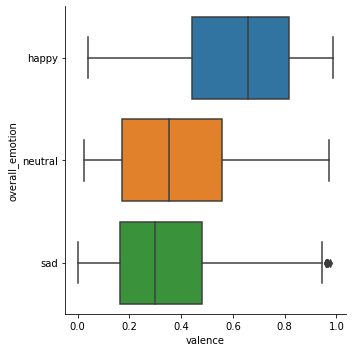

In [224]:
sns.catplot(x="valence", y="overall_emotion", data=dfc, kind='box')
plt.tight_layout()

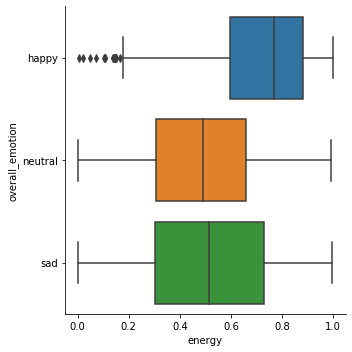

In [225]:
sns.catplot(x="energy", y="overall_emotion", data=dfc, kind='box')
plt.tight_layout()

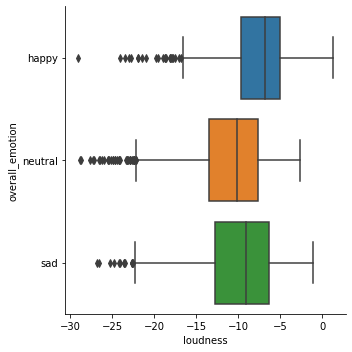

In [226]:
sns.catplot(x="loudness", y="overall_emotion", data=dfc[dfc.loudness>-30], kind='box')
plt.tight_layout()

In [204]:
# Input Spotify features

# Test accuracy of ~0.52
#features = dfc[['danceability', 'energy', 'key', 'loudness', 'mode', 
#                'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
#                'valence', 'tempo', 'duration_ms', 'time_signature']]

# Test accuracy of ~0.60 (without overfitting, compared with ~0.58 CV accuracy)
#features = dfc[['danceability', 'energy', 'loudness', 'mode', 
#                'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
#                'valence', 'duration_ms']]

# Test accuracy of only about ~0.56, so actually need
# other features to reach ~0.60
#features = dfc[['valence', 'energy', 'loudness', 'instrumentalness', 
#                'acousticness', 'speechiness', 'danceability']]

features = dfc[['danceability', 'energy', 'loudness', 
                'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
                'valence', 'duration_ms']]

# Output labels for emotion classification
labels = dfc[['overall_emotion']]

# Create training/testing split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)
print("Using a training dataset of size:", len(x_train))
print("Using a test dataset of size:", len(x_test))

Using a training dataset of size: 2832
Using a test dataset of size: 708


In [205]:
# Scale features which will be used in model fitting
# (for both training and testing datasets)
scale_train = StandardScaler().fit(x_train)
train_features = scale_train.transform(x_train)
scale_test = StandardScaler().fit(x_test)
test_features = scale_test.transform(x_test)

In [206]:
# Perform a comprehensive grid search to optimize parameters for Random Forest
n_estimators = [100, 500, 1000, 3000, 5000]
#n_estimators = [100, 500, 1000, 2000, 3000]
max_depth = [5, 15, 30, 50]
min_samples_split = [2, 10, 100]
#min_samples_split = [2, 10, 20]
min_samples_leaf = [1, 5, 10]
#min_samples_leaf = [1, 3, 5]

param_grid = {'n_estimators': n_estimators, 'max_depth' : max_depth, 'min_samples_split' : min_samples_split, 'min_samples_leaf' : min_samples_leaf}
grid_search = GridSearchCV(RandomForestClassifier(random_state = 1), param_grid, cv=3)
grid_search.fit(train_features, y_train.values.ravel())
grid_search.best_params_
print('Optimized hyperparameters:', grid_search.best_params_)

rfc = RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'], 
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'] )

Optimized hyperparameters: {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


In [207]:
# Fit the training dataset
rfc.fit(train_features, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Test accuracy of 55.50847457627118 %
Best averaged CV accuracy was 58.58050847457626 %


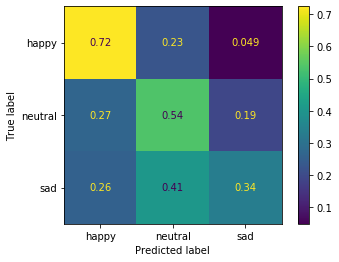

In [209]:
# Run the model on the test data
y_pred = rfc.predict(test_features)
print("Test accuracy of", np.sum(y_test['overall_emotion'].values==y_pred)*100./(len(y_pred)*1.), "%")
print('Best averaged CV accuracy was', grid_search.best_score_*100., '%')

# Plot a confusion matrix to get classification errors
plot_confusion_matrix(rfc, test_features, y_test, normalize='true')

<-- Feature importance -->
valence : 0.16030364752568313
energy : 0.14217613787993533
loudness : 0.10894948751134793
duration_ms : 0.10655740951035438
acousticness : 0.1009278860417444
speechiness : 0.1006762307196129
danceability : 0.09551448193316288
instrumentalness : 0.09530758801926054
liveness : 0.08958713085889858


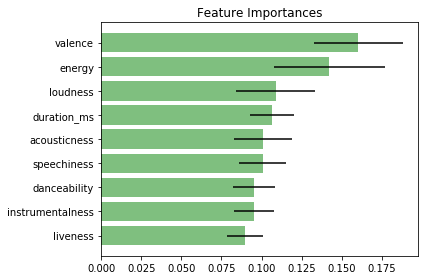

In [210]:
# Show feature importances (sorted)
idx = sorted(range(len(rfc.feature_importances_)), key=lambda k: rfc.feature_importances_[k], reverse=True)
#for i,f in enumerate(features):
print('<-- Feature importance -->')
for i in idx:
    print(features.columns[i], ':', rfc.feature_importances_[i])

# Sort features by importance (not reversed) for bar plotting
idx = sorted(range(len(rfc.feature_importances_)), key=lambda k: rfc.feature_importances_[k])
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

# Create horizontal bar plot breaking down feature importances,
# with errors derived from standard deviation of all tree estimators in forest
y_axis = range(features.shape[1])
plt.figure()
plt.title("Feature Importances")
plt.barh(y_axis, importances[idx], color="g", xerr=std[idx], align="center", alpha=0.5)
plt.yticks(y_axis, features.columns[idx])
plt.tight_layout()

# Process Last.fm Database for Emotional Tags

In [312]:
# Process Last.fm database to get songs with emotional tags
#df_db = process_lastfm_dbs()
#df_db.to_csv('Processed_LastFM_4Emotions.csv', index=False)

In [359]:
from ast import literal_eval

# Read in previously processed songs with emotional tags
df_db = pd.read_csv('Processed_LastFM_4Emotions.csv')

df_db['happy_tags'] = df_db['happy_tags'].apply(literal_eval)
df_db['calm_tags'] = df_db['calm_tags'].apply(literal_eval)
df_db['sad_tags'] = df_db['sad_tags'].apply(literal_eval)
df_db['angry_tags'] = df_db['angry_tags'].apply(literal_eval)

# Separate songs into separate emotional dataframes for downsampling of majority classes
df_happy = df_db[(df_db['num_happy_tags']>0) & (df_db['num_calm_tags']==0) & (df_db['num_sad_tags']==0) & (df_db['num_angry_tags']==0)]
df_calm = df_db[(df_db['num_happy_tags']==0) & (df_db['num_calm_tags']>0) & (df_db['num_sad_tags']==0) & (df_db['num_angry_tags']==0)]
df_sad = df_db[(df_db['num_happy_tags']==0) & (df_db['num_calm_tags']==0) & (df_db['num_sad_tags']>0) & (df_db['num_angry_tags']==0)]
df_angry = df_db[(df_db['num_happy_tags']==0) & (df_db['num_calm_tags']==0) & (df_db['num_sad_tags']==0) & (df_db['num_angry_tags']>0)]

# For now, keep songs associated with frustrated/frustration
#df_angry = df_angry[~df_angry.angry_tags.str.join(' ').str.contains('frustrated')]


In [363]:
# Downsample the majority classes to the minority class (angry)
df_happy = resample(df_happy, replace=False, n_samples=len(df_angry), random_state=2)
df_calm = resample(df_calm, replace=False, n_samples=len(df_angry), random_state=3)
df_sad = resample(df_sad, replace=False, n_samples=len(df_angry), random_state=4)

# Pre-label each dataframe appropriately
df_happy['overall_emotion'] = 'happy'
df_calm['overall_emotion'] = 'calm'
df_sad['overall_emotion'] = 'sad'
df_angry['overall_emotion'] = 'angry'

# Concatenate into single down-sampled dataframe
df_ds = pd.concat([df_happy, df_calm, df_sad, df_angry])
df_ds


/Users/jecutter/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,track_id,artist,title,happy_tags,num_happy_tags,calm_tags,num_calm_tags,sad_tags,num_sad_tags,angry_tags,num_angry_tags,overall_emotion
40063,TRBALRR128F429625D,Britney Spears,Can't Make You Love Me,"[fun, fun sex, fun music, fun pop music]",4,[],0,[],0,[],0,happy
38138,TRAZYHM128F14821A0,Zoegirl,Ordinary Day,[happy],1,[],0,[],0,[],0,happy
29656,TRMKGXX128F931D3ED,Jimmy Cliff,Hard Road To Travel,[happy hippo],1,[],0,[],0,[],0,happy
55200,TREBQJU128F4292595,Jordan Rudess,Dance on a Volcano,[happy],1,[],0,[],0,[],0,happy
6943,TRWQIHV128F930E3CA,Tiga,Beep Beep Beep,[happy],1,[],0,[],0,[],0,happy
...,...,...,...,...,...,...,...,...,...,...,...,...
86223,TRVVBNV128F42BC62F,Modest Mouse,King Rat,[],0,[],0,[],0,"[angry, angry god]",2,angry
86228,TRVVNVJ128F92C6911,United Nations,I Keep Living The Same Day,[],0,[],0,[],0,[emo violence],1,angry
86255,TRVVPHP128F931C3D4,Filter,Captain Bligh,[],0,[],0,[],0,[anger is a gift],1,angry
86284,TRVVUYY128E0781E92,Cracker,I Hate My Generation,[],0,[],0,[],0,[angry],1,angry


# Query Spotify for Audio Features (Full Set)

In [387]:
# Grab audio features for all songs from the Spotify API
#fetch_spotify_features(df_ds)


Sleeping on counter = 50 for 5 seconds...
Sleeping on counter = 100 for 5 seconds...
Sleeping on counter = 150 for 5 seconds...
Sleeping on counter = 200 for 5 seconds...
[{'danceability': 0.664, 'energy': 0.713, 'key': 3, 'loudness': -6.587, 'mode': 0, 'speechiness': 0.0382, 'acousticness': 0.18, 'instrumentalness': 0, 'liveness': 0.313, 'valence': 0.578, 'tempo': 96.974, 'type': 'audio_features', 'id': '672BzTe9bbbxl3wBYi6Yp1', 'uri': 'spotify:track:672BzTe9bbbxl3wBYi6Yp1', 'track_href': 'https://api.spotify.com/v1/tracks/672BzTe9bbbxl3wBYi6Yp1', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/672BzTe9bbbxl3wBYi6Yp1', 'duration_ms': 250587, 'time_signature': 4}]
Sleeping on counter = 250 for 5 seconds...
Sleeping on counter = 300 for 5 seconds...
Sleeping on counter = 350 for 5 seconds...
Sleeping on counter = 400 for 5 seconds...
[{'danceability': 0.577, 'energy': 0.25, 'key': 6, 'loudness': -10.598, 'mode': 0, 'speechiness': 0.0413, 'acousticness': 0.743, 'instrumentalne

Sleeping on counter = 2450 for 5 seconds...
Sleeping on counter = 2500 for 5 seconds...
Sleeping on counter = 2550 for 5 seconds...
Sleeping on counter = 2600 for 5 seconds...
[{'danceability': 0.42, 'energy': 0.368, 'key': 9, 'loudness': -13.941, 'mode': 0, 'speechiness': 0.0369, 'acousticness': 0.903, 'instrumentalness': 0.497, 'liveness': 0.109, 'valence': 0.0971, 'tempo': 133.88, 'type': 'audio_features', 'id': '2lk9IzlRJgxJC0TnaR3Qr4', 'uri': 'spotify:track:2lk9IzlRJgxJC0TnaR3Qr4', 'track_href': 'https://api.spotify.com/v1/tracks/2lk9IzlRJgxJC0TnaR3Qr4', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2lk9IzlRJgxJC0TnaR3Qr4', 'duration_ms': 326840, 'time_signature': 4}]
Sleeping on counter = 2650 for 5 seconds...
Sleeping on counter = 2700 for 5 seconds...
Sleeping on counter = 2750 for 5 seconds...
Sleeping on counter = 2800 for 5 seconds...
[{'danceability': 0.535, 'energy': 0.343, 'key': 0, 'loudness': -11.034, 'mode': 1, 'speechiness': 0.0322, 'acousticness': 0.917,

Sleeping on counter = 4850 for 5 seconds...
Sleeping on counter = 4900 for 5 seconds...
Sleeping on counter = 4950 for 5 seconds...
Sleeping on counter = 5000 for 5 seconds...
[{'danceability': 0.551, 'energy': 0.386, 'key': 8, 'loudness': -8.07, 'mode': 0, 'speechiness': 0.0291, 'acousticness': 0.402, 'instrumentalness': 0, 'liveness': 0.148, 'valence': 0.322, 'tempo': 65.587, 'type': 'audio_features', 'id': '0C4U0LCl73a0vknPVCZvaB', 'uri': 'spotify:track:0C4U0LCl73a0vknPVCZvaB', 'track_href': 'https://api.spotify.com/v1/tracks/0C4U0LCl73a0vknPVCZvaB', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0C4U0LCl73a0vknPVCZvaB', 'duration_ms': 224360, 'time_signature': 4}]
Sleeping on counter = 5050 for 5 seconds...
Sleeping on counter = 5100 for 5 seconds...
Sleeping on counter = 5150 for 5 seconds...
Sleeping on counter = 5200 for 5 seconds...
[{'danceability': 0.598, 'energy': 0.398, 'key': 0, 'loudness': -14.208, 'mode': 1, 'speechiness': 0.0613, 'acousticness': 0.152, 'inst

Sleeping on counter = 7250 for 5 seconds...
Sleeping on counter = 7300 for 5 seconds...
Sleeping on counter = 7350 for 5 seconds...
Sleeping on counter = 7400 for 5 seconds...
[{'danceability': 0.289, 'energy': 0.818, 'key': 11, 'loudness': -6.105, 'mode': 0, 'speechiness': 0.066, 'acousticness': 0.000153, 'instrumentalness': 0.1, 'liveness': 0.211, 'valence': 0.559, 'tempo': 89.938, 'type': 'audio_features', 'id': '6JhkNS62fXEiSTVKvou61C', 'uri': 'spotify:track:6JhkNS62fXEiSTVKvou61C', 'track_href': 'https://api.spotify.com/v1/tracks/6JhkNS62fXEiSTVKvou61C', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6JhkNS62fXEiSTVKvou61C', 'duration_ms': 257360, 'time_signature': 4}]
Sleeping on counter = 7450 for 5 seconds...
Sleeping on counter = 7500 for 5 seconds...
Sleeping on counter = 7550 for 5 seconds...
Sleeping on counter = 7600 for 5 seconds...
[{'danceability': 0.638, 'energy': 0.905, 'key': 4, 'loudness': -6.554, 'mode': 0, 'speechiness': 0.0595, 'acousticness': 0.00025

Sleeping on counter = 9650 for 5 seconds...
Sleeping on counter = 9700 for 5 seconds...
Sleeping on counter = 9750 for 5 seconds...
Sleeping on counter = 9800 for 5 seconds...
[{'danceability': 0.282, 'energy': 0.869, 'key': 2, 'loudness': -8.32, 'mode': 1, 'speechiness': 0.0833, 'acousticness': 0.000799, 'instrumentalness': 0.0668, 'liveness': 0.514, 'valence': 0.281, 'tempo': 164.38, 'type': 'audio_features', 'id': '22AYE62irnblz8OMUzz6Qi', 'uri': 'spotify:track:22AYE62irnblz8OMUzz6Qi', 'track_href': 'https://api.spotify.com/v1/tracks/22AYE62irnblz8OMUzz6Qi', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/22AYE62irnblz8OMUzz6Qi', 'duration_ms': 177733, 'time_signature': 4}]
Sleeping on counter = 9850 for 5 seconds...
Sleeping on counter = 9900 for 5 seconds...
Sleeping on counter = 9950 for 5 seconds...
Sleeping on counter = 10000 for 5 seconds...
[{'danceability': 0.282, 'energy': 0.869, 'key': 2, 'loudness': -8.32, 'mode': 1, 'speechiness': 0.0833, 'acousticness': 0.000

KeyboardInterrupt: 

In [424]:
#df_ds.to_csv('Total_Spotify_4Emotion_MessUp.csv')
#df_ds.head(8400).to_csv('Total_Spotify_4Emotion_GoodPortion.csv')
#df_ds = pd.read_csv('Total_Spotify_4Emotion_MessUp.csv')
#df_ds2 = df_ds.iloc[8399:14000]

In [425]:
# Continue to fetch data from Spotify...
#fetch_spotify_features(df_ds2)
#df_ds2

Sleeping on counter = 50 for 5 seconds...
Sleeping on counter = 100 for 5 seconds...
Sleeping on counter = 150 for 5 seconds...
Sleeping on counter = 200 for 5 seconds...
[{'danceability': 0.589, 'energy': 0.694, 'key': 5, 'loudness': -9.043, 'mode': 0, 'speechiness': 0.0288, 'acousticness': 0.0568, 'instrumentalness': 0.866, 'liveness': 0.18, 'valence': 0.44, 'tempo': 127.886, 'type': 'audio_features', 'id': '4jy7tsWx2FZjXspLV5uZkQ', 'uri': 'spotify:track:4jy7tsWx2FZjXspLV5uZkQ', 'track_href': 'https://api.spotify.com/v1/tracks/4jy7tsWx2FZjXspLV5uZkQ', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4jy7tsWx2FZjXspLV5uZkQ', 'duration_ms': 417808, 'time_signature': 4}]
Sleeping on counter = 250 for 5 seconds...
Sleeping on counter = 300 for 5 seconds...
Sleeping on counter = 350 for 5 seconds...
Sleeping on counter = 400 for 5 seconds...
[{'danceability': 0.577, 'energy': 0.25, 'key': 6, 'loudness': -10.598, 'mode': 0, 'speechiness': 0.0413, 'acousticness': 0.743, 'instrumen

Sleeping on counter = 2450 for 5 seconds...
Sleeping on counter = 2500 for 5 seconds...
Sleeping on counter = 2550 for 5 seconds...
Sleeping on counter = 2600 for 5 seconds...
[{'danceability': 0.387, 'energy': 0.897, 'key': 5, 'loudness': -3.812, 'mode': 0, 'speechiness': 0.0654, 'acousticness': 0.0465, 'instrumentalness': 4.62e-05, 'liveness': 0.0697, 'valence': 0.229, 'tempo': 132.651, 'type': 'audio_features', 'id': '0huQmOxKiT2cZHBdFijeEM', 'uri': 'spotify:track:0huQmOxKiT2cZHBdFijeEM', 'track_href': 'https://api.spotify.com/v1/tracks/0huQmOxKiT2cZHBdFijeEM', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0huQmOxKiT2cZHBdFijeEM', 'duration_ms': 193987, 'time_signature': 3}]
Sleeping on counter = 2650 for 5 seconds...
Sleeping on counter = 2700 for 5 seconds...
Sleeping on counter = 2750 for 5 seconds...
Sleeping on counter = 2800 for 5 seconds...
[{'danceability': 0.556, 'energy': 0.711, 'key': 0, 'loudness': -6.776, 'mode': 0, 'speechiness': 0.0272, 'acousticness': 0.

Sleeping on counter = 4850 for 5 seconds...
Sleeping on counter = 4900 for 5 seconds...
Sleeping on counter = 4950 for 5 seconds...
Sleeping on counter = 5000 for 5 seconds...
[{'danceability': 0.232, 'energy': 0.933, 'key': 2, 'loudness': -4.266, 'mode': 1, 'speechiness': 0.0694, 'acousticness': 3.34e-05, 'instrumentalness': 0.916, 'liveness': 0.351, 'valence': 0.262, 'tempo': 167.943, 'type': 'audio_features', 'id': '4lW89y0AxVw4La7mo1x3BJ', 'uri': 'spotify:track:4lW89y0AxVw4La7mo1x3BJ', 'track_href': 'https://api.spotify.com/v1/tracks/4lW89y0AxVw4La7mo1x3BJ', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4lW89y0AxVw4La7mo1x3BJ', 'duration_ms': 498547, 'time_signature': 4}]
Sleeping on counter = 5050 for 5 seconds...
Sleeping on counter = 5100 for 5 seconds...
Sleeping on counter = 5150 for 5 seconds...
Sleeping on counter = 5200 for 5 seconds...
[{'danceability': 0.387, 'energy': 0.646, 'key': 9, 'loudness': -7.471, 'mode': 0, 'speechiness': 0.0313, 'acousticness': 0.04

/Users/jecutter/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jecutter/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jecutter/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,Unnamed: 0,track_id,artist,title,happy_tags,num_happy_tags,calm_tags,num_calm_tags,sad_tags,num_sad_tags,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
8399,79992,TRQKRCM12903C9EBB7,Ipanema Beach Orchestra_ Jorge Serafim,MacArthur Park,[],0,['relaxing instrumental'],1,[],0,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8400,74442,TRTUWYL12903CB9CAA,Howie Day,Be There,[],0,['relaxing'],1,[],0,...,-5.765,1,0.0499,0.0971,0,0.105,0.224,114.038,232053,4
8401,18268,TRIUVKL128F92EE036,Europe,Tomorrow,[],0,['nice n soothing'],1,[],0,...,-12.63,0,0.0263,0.55,0,0.322,0.1,105.617,184107,3
8402,45757,TRSRYSD128F4263A08,Tom Petty,Alright For Now,[],0,['relax rock'],1,[],0,...,-21.445,1,0.0338,0.823,4.22e-05,0.108,0.404,75.652,120867,4
8403,21726,TRXHYTT128F147CCDF,Pharrell,Raspy **** (Explicit),[],0,['chill'],1,[],0,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,66641,TRZRYWY12903CE2120,Eisblume,beyond the haze,[],0,[],0,['sorrowed heart of sadness'],1,...,-7.38,1,0.0348,0.716,0,0.175,0.29,103.969,266813,4
13996,77444,TRQCYZM128F93456C4,Bad Astronaut,These Days,[],0,[],0,['sad'],1,...,-6.17,0,0.03,0.0431,0.0237,0.116,0.147,135.325,257160,4
13997,31548,TRRFBWR128F4229565,Slut,Andy,[],0,[],0,['sad'],1,...,-5.081,1,0.0297,0.000129,0.28,0.0852,0.193,140.016,288000,4
13998,43398,TRNNKLU128F92EB5B8,Robyn Hitchcock_ The Venus 3,TLC,[],0,[],0,"['sad', 'sad but true']",2,...,-10.72,1,0.0307,0.159,0.00386,0.194,0.201,105.688,226240,3


In [426]:
# 2nd chunk of Spotify data
#df_ds2.to_csv('Total_Spotify_4Emotion_Part2.csv')

In [432]:
# Last chunk of Spotify data
#df_ds3 = df_ds.iloc[14000:]
#fetch_spotify_features(df_ds3)
#df_ds3

Sleeping on counter = 50 for 5 seconds...
Sleeping on counter = 100 for 5 seconds...
Sleeping on counter = 150 for 5 seconds...
Sleeping on counter = 200 for 5 seconds...
[{'danceability': 0.685, 'energy': 0.584, 'key': 5, 'loudness': -10.616, 'mode': 0, 'speechiness': 0.0276, 'acousticness': 0.288, 'instrumentalness': 0.00918, 'liveness': 0.124, 'valence': 0.939, 'tempo': 134.546, 'type': 'audio_features', 'id': '5vmRQ3zELMLUQPo2FLQ76x', 'uri': 'spotify:track:5vmRQ3zELMLUQPo2FLQ76x', 'track_href': 'https://api.spotify.com/v1/tracks/5vmRQ3zELMLUQPo2FLQ76x', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5vmRQ3zELMLUQPo2FLQ76x', 'duration_ms': 302413, 'time_signature': 4}]
Sleeping on counter = 250 for 5 seconds...
Sleeping on counter = 300 for 5 seconds...
Sleeping on counter = 350 for 5 seconds...
Sleeping on counter = 400 for 5 seconds...
[{'danceability': 0.555, 'energy': 0.875, 'key': 0, 'loudness': -5.287, 'mode': 1, 'speechiness': 0.0335, 'acousticness': 0.0307, 'inst

Sleeping on counter = 2450 for 5 seconds...
Sleeping on counter = 2500 for 5 seconds...
Sleeping on counter = 2550 for 5 seconds...
Sleeping on counter = 2600 for 5 seconds...
[{'danceability': 0.364, 'energy': 0.974, 'key': 11, 'loudness': -2.62, 'mode': 1, 'speechiness': 0.137, 'acousticness': 4.39e-05, 'instrumentalness': 0.0002, 'liveness': 0.155, 'valence': 0.28, 'tempo': 116.147, 'type': 'audio_features', 'id': '64sLwEYbRPxvNpfLuO8jLg', 'uri': 'spotify:track:64sLwEYbRPxvNpfLuO8jLg', 'track_href': 'https://api.spotify.com/v1/tracks/64sLwEYbRPxvNpfLuO8jLg', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/64sLwEYbRPxvNpfLuO8jLg', 'duration_ms': 238907, 'time_signature': 4}]
Sleeping on counter = 2650 for 5 seconds...
Sleeping on counter = 2700 for 5 seconds...
Sleeping on counter = 2750 for 5 seconds...
Sleeping on counter = 2800 for 5 seconds...
[{'danceability': 0.297, 'energy': 0.918, 'key': 9, 'loudness': -5.433, 'mode': 0, 'speechiness': 0.0996, 'acousticness': 0.000

Sleeping on counter = 4850 for 5 seconds...
Sleeping on counter = 4900 for 5 seconds...
Sleeping on counter = 4950 for 5 seconds...
Sleeping on counter = 5000 for 5 seconds...
[{'danceability': 0.395, 'energy': 0.988, 'key': 11, 'loudness': -4.877, 'mode': 1, 'speechiness': 0.111, 'acousticness': 0.0257, 'instrumentalness': 0.146, 'liveness': 0.353, 'valence': 0.365, 'tempo': 140.849, 'type': 'audio_features', 'id': '62pJJQjiTaTsFYFjDIYjYU', 'uri': 'spotify:track:62pJJQjiTaTsFYFjDIYjYU', 'track_href': 'https://api.spotify.com/v1/tracks/62pJJQjiTaTsFYFjDIYjYU', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/62pJJQjiTaTsFYFjDIYjYU', 'duration_ms': 263573, 'time_signature': 4}]
Sleeping on counter = 5050 for 5 seconds...
Sleeping on counter = 5100 for 5 seconds...
Sleeping on counter = 5150 for 5 seconds...
Sleeping on counter = 5200 for 5 seconds...
[{'danceability': 0.289, 'energy': 0.938, 'key': 1, 'loudness': -6.083, 'mode': 1, 'speechiness': 0.163, 'acousticness': 0.00011

/Users/jecutter/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jecutter/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jecutter/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,Unnamed: 0,track_id,artist,title,happy_tags,num_happy_tags,calm_tags,num_calm_tags,sad_tags,num_sad_tags,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
14000,41051,TRBPPTX128EF34409D,Michael Feinstein / Maynard Ferguson,Close Your Eyes,[],0,[],0,['sad sad sad'],1,...,-10.261,0,0.0881,0.763,0.000176,0.0902,0.511,98.659,178533,4
14001,22043,TRXMXCQ128F428525F,Betty Davis,In the Meantime,[],0,[],0,['sad'],1,...,-8.619,0,0.0288,0.317,0.278,0.135,0.506,80.907,166560,4
14002,53835,TRDVBPX128F9308068,R.E.M.,Camera,[],0,[],0,['sad'],1,...,-8.868,1,0.0348,0.102,0.00362,0.138,0.262,95.217,351173,4
14003,84060,TRVOKVF128F4262ABD,Ricky Van Shelton,I'll Leave This World Loving You,[],0,[],0,['sad'],1,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
14004,54079,TREJFCE128F1452E84,The Human League,Mirror Man (Extended Version),[],0,[],0,['sad'],1,...,-8.128,1,0.0396,0.00348,0.000644,0.0601,0.422,133.145,262533,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19899,86223,TRVVBNV128F42BC62F,Modest Mouse,King Rat,[],0,[],0,[],0,...,-5.116,0,0.0394,0.0536,0.000179,0.139,0.716,177.227,330573,4
19900,86228,TRVVNVJ128F92C6911,United Nations,I Keep Living The Same Day,[],0,[],0,[],0,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
19901,86255,TRVVPHP128F931C3D4,Filter,Captain Bligh,[],0,[],0,[],0,...,-7.196,1,0.0475,0.000328,0.00216,0.137,0.359,174.017,312467,4
19902,86284,TRVVUYY128E0781E92,Cracker,I Hate My Generation,[],0,[],0,[],0,...,-4.097,1,0.0545,0.000149,0.000105,0.372,0.524,123.767,176933,4


In [433]:
# 3rd chunk of Spotify data
#df_ds3.to_csv('Total_Spotify_4Emotion_Part3.csv')

In [438]:
# Concatenate all Spotify datasets
df_ds1 = pd.read_csv('Total_Spotify_4Emotion_GoodPortion.csv', index_col=0)
df_ds2 = pd.read_csv('Total_Spotify_4Emotion_Part2.csv', index_col=0)
df_ds3 = pd.read_csv('Total_Spotify_4Emotion_Part3.csv', index_col=0)
df_ds = pd.concat([df_ds1, df_ds2, df_ds3])
df_ds = df_ds.drop(columns=['Unnamed: 0.1'])
df_ds = df_ds.dropna()
df_ds

,track_id,artist,title,happy_tags,num_happy_tags,calm_tags,num_calm_tags,sad_tags,num_sad_tags,angry_tags,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
38138,TRAZYHM128F14821A0,Zoegirl,Ordinary Day,['happy'],1,[],0,[],0,[],...,-3.274,1.0,0.0357,0.001390,0.362000,0.2990,0.731,129.990,241573.0,4.0
29656,TRMKGXX128F931D3ED,Jimmy Cliff,Hard Road To Travel,['happy hippo'],1,[],0,[],0,[],...,-15.884,1.0,0.1380,0.146000,0.000000,0.1660,0.941,169.024,157773.0,4.0
55200,TREBQJU128F4292595,Jordan Rudess,Dance on a Volcano,['happy'],1,[],0,[],0,[],...,-4.864,1.0,0.0594,0.019800,0.025500,0.2230,0.286,154.885,524813.0,4.0
6943,TRWQIHV128F930E3CA,Tiga,Beep Beep Beep,['happy'],1,[],0,[],0,[],...,-4.301,1.0,0.0376,0.039400,0.837000,0.0839,0.756,127.978,229760.0,4.0
26186,TROWILC12903CBB643,Annie Lennox,Walking On Broken Glass,['happy'],1,[],0,[],0,[],...,-8.450,1.0,0.0281,0.215000,0.000001,0.1050,0.807,115.008,253296.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19897,TRVUGEB128F4283832,Love,Signed D.C.,[],0,[],0,[],0,['mad men'],...,-15.145,0.0,0.0410,0.472000,0.001650,0.0992,0.155,83.335,165427.0,3.0
19899,TRVVBNV128F42BC62F,Modest Mouse,King Rat,[],0,[],0,[],0,"['angry', 'angry god']",...,-5.116,0.0,0.0394,0.053600,0.000179,0.1390,0.716,177.227,330573.0,4.0
19901,TRVVPHP128F931C3D4,Filter,Captain Bligh,[],0,[],0,[],0,['anger is a gift'],...,-7.196,1.0,0.0475,0.000328,0.002160,0.1370,0.359,174.017,312467.0,4.0
19902,TRVVUYY128E0781E92,Cracker,I Hate My Generation,[],0,[],0,[],0,['angry'],...,-4.097,1.0,0.0545,0.000149,0.000105,0.3720,0.524,123.767,176933.0,4.0


# Building a Classifier for Full Training Set

In [277]:
# Write out complete dataset
#df_ds.to_csv('Total_Spotify_4Emotion_AllParts.csv', index=False)

# Read in complete dataset
df_ds = pd.read_csv('Total_Spotify_4Emotion_AllParts.csv')

# Create a linear loudness variable by converting from decibels to gain
df_ds['loudness_linear'] = 10**(df_ds['loudness']/20.)


Text(0.5, 0, 'Loudness (Linear Scale)')

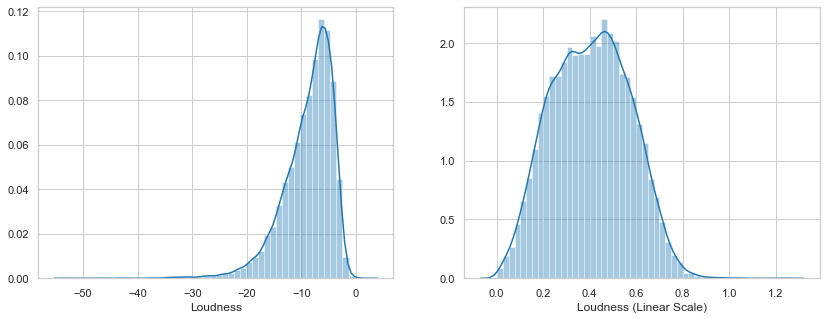

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plt.axes(ax[0])
sns.distplot(df_ds.loudness)
ax[0].set_xlabel('Loudness')
plt.axes(ax[1])
sns.distplot(df_ds.loudness_linear)
ax[1].set_xlabel('Loudness (Linear Scale)')


[Text(0, 0.5, 'Emotional Label'), Text(0.5, 0, 'Loudness (Linear Scale)')]

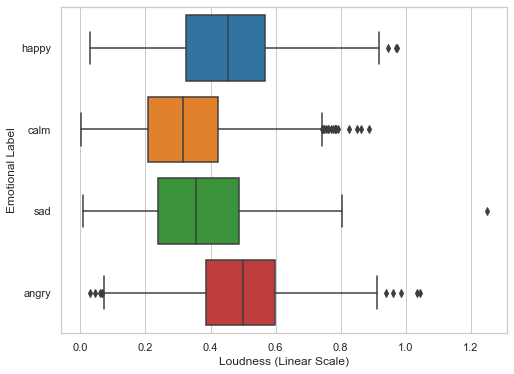

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.boxplot(x="loudness_linear", y="overall_emotion", data=df_ds, ax=ax)
ax.set(xlabel='Loudness (Linear Scale)', ylabel='Emotional Label')
#ax.set(xlabel='Instrumentalness', ylabel='Emotional Label')

In [7]:
# Input Spotify features
features = df_ds[['danceability', 'energy', 'key', 'loudness_linear', 
            'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'duration_ms']]

# Output labels for emotion classification
labels = df_ds[['overall_emotion']]

# Create training/testing split
x_train, x_test, y_train, y_test = split_by_emotion(features, labels)
print("Using a training dataset of size:", len(x_train))
print("Using a test dataset of size:", len(x_test))

Using a training dataset of size: 13594
Using a test dataset of size: 3401


In [8]:
# Scale features which will be used in model fitting
# (for both training and testing datasets)
scale_train = StandardScaler().fit(x_train)
train_features = scale_train.transform(x_train)
#scale_test = StandardScaler().fit(x_test)
#test_features = scale_test.transform(x_test)
test_features = scale_train.transform(x_test)

In [522]:
# Perform a comprehensive grid search to optimize parameters for Random Forest
#n_estimators = [100, 500, 1000, 3000, 5000]
n_estimators = [500, 1000, 2000, 3000]
max_depth = [5, 15, 30]
#min_samples_split = [2, 10, 100]
min_samples_split = [2, 5]
#min_samples_leaf = [1, 5, 10]
min_samples_leaf = [1, 3, 5]

param_grid = {'n_estimators': n_estimators, 'max_depth' : max_depth, 'min_samples_split' : min_samples_split, 'min_samples_leaf' : min_samples_leaf}
grid_search = GridSearchCV(RandomForestClassifier(random_state = 1), param_grid, cv=3)
grid_search.fit(train_features, y_train.values.ravel())
grid_search.best_params_
print('Optimized hyperparameters:', grid_search.best_params_)

rfc = RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'], 
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'] )

Optimized hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}


In [9]:
# Fit the training dataset
rfc = RandomForestClassifier(
    n_estimators=2000, 
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1, 
    random_state = 1)
rfc.fit(train_features, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

Test accuracy of 62.06997941781829 %


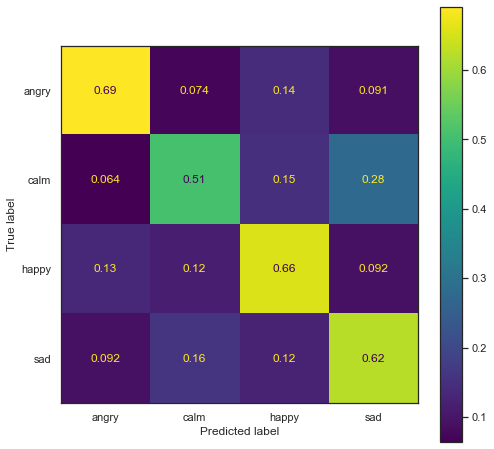

In [10]:
# Run the model on the test data
y_pred = rfc.predict(test_features)
print("Test accuracy of", np.sum(y_test['overall_emotion'].values==y_pred)*100./(len(y_pred)*1.), "%")
#print('Best averaged CV accuracy was', grid_search.best_score_*100., '%')

# Plot a confusion matrix to get classification errors
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plot_confusion_matrix(rfc, test_features, y_test, normalize='true', ax=ax)

<-- Feature importance -->
energy : 0.1327563621876977
valence : 0.1209470296014102
acousticness : 0.1134732494231056
speechiness : 0.10829439750633514
danceability : 0.09170357934018554
duration_ms : 0.08851972522183296
loudness_linear : 0.08185015200562079
instrumentalness : 0.08087182032130741
tempo : 0.07416688793282833
liveness : 0.06660521140296148
key : 0.04081158505671498


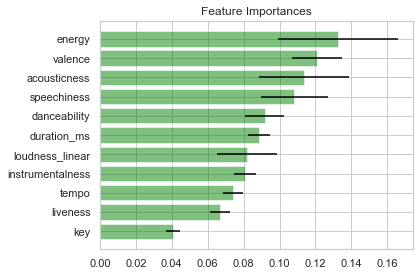

In [9]:
# Show feature importances (sorted)
idx = sorted(range(len(rfc.feature_importances_)), key=lambda k: rfc.feature_importances_[k], reverse=True)
#for i,f in enumerate(features):
print('<-- Feature importance -->')
for i in idx:
    print(features.columns[i], ':', rfc.feature_importances_[i])

# Sort features by importance (not reversed) for bar plotting
idx = sorted(range(len(rfc.feature_importances_)), key=lambda k: rfc.feature_importances_[k])
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

# Create horizontal bar plot breaking down feature importances,
# with errors derived from standard deviation of all tree estimators in forest
y_axis = range(features.shape[1])
plt.figure()
plt.title("Feature Importances")
plt.barh(y_axis, importances[idx], color="g", xerr=std[idx], align="center", alpha=0.5)
plt.yticks(y_axis, features.columns[idx])
plt.tight_layout()

In [11]:
# Pickle model and write to a file for app use
#filename = 'first_rfc_model.pkl'
#pickle.dump(rfc, open(filename, 'wb'))

#from joblib import dump
#dump(rfc, 'first_rfc_model.joblib')


['first_rfc_model.joblib']

# Query Genius API for Song Lyrics (Full Training Set)

In [111]:
#df_red = df_ds[df_ds.overall_emotion == 'happy']
#df_red = df_red[(df_red['instrumentalness'] < 0.45) | (df_red['speechiness'] > 0.33)]
#df_red

In [285]:
%%time

# Read in complete dataset
df_ds = pd.read_csv('Total_Spotify_4Emotion_AllParts.csv')

# Create a linear loudness variable by converting from decibels to gain
df_ds['loudness_linear'] = 10**(df_ds['loudness']/20.)

# Get lyrics for each song in the training dataset
df_ds = df_ds.drop_duplicates(['artist', 'title'])
#fetch_training_lyrics(df_ds, 'happy', 1000, 3500)
#fetch_training_lyrics(df_ds, 'calm', 1000, 3500)
#fetch_training_lyrics(df_ds, 'sad', 1000, 3500)
#fetch_training_lyrics(df_ds, 'angry', 1000, 3500)


/Users/jecutter/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Fetching lyrics for song # 10 ...
Fetching lyrics for song # 20 ...
Fetching lyrics for song # 30 ...
Fetching lyrics for song # 40 ...
Fetching lyrics for song # 50 ...
Fetching lyrics for song # 60 ...
Fetching lyrics for song # 70 ...
Fetching lyrics for song # 80 ...
Fetching lyrics for song # 90 ...
Fetching lyrics for song # 100 ...
Fetching lyrics for song # 110 ...
Fetching lyrics for song # 120 ...
Fetching lyrics for song # 130 ...
Fetching lyrics for song # 140 ...
Fetching lyrics for song # 150 ...
Fetching lyrics for song # 160 ...
Fetching lyrics for song # 170 ...
Fetching lyrics for song # 180 ...
Fetching lyrics for song # 190 ...
Fetching lyrics for song # 200 ...
Fetching lyrics for song # 210 ...
Fetching lyrics for song # 220 ...
Fetching lyrics for song # 230 ...
Fetching lyrics for song # 240 ...
Fetching lyrics for song # 250 ...
Fetching lyrics for song # 260 ...
Fetching lyrics for song # 270 ...
Fetching lyrics for song # 280 ...
Fetching lyrics for song # 29

Fetching lyrics for song # 2320 ...
Fetching lyrics for song # 2330 ...
Fetching lyrics for song # 2340 ...
Fetching lyrics for song # 2350 ...
Fetching lyrics for song # 2360 ...
Fetching lyrics for song # 2370 ...
Fetching lyrics for song # 2380 ...
Fetching lyrics for song # 10 ...
Fetching lyrics for song # 20 ...
Fetching lyrics for song # 30 ...
Fetching lyrics for song # 40 ...
Fetching lyrics for song # 50 ...
Fetching lyrics for song # 60 ...
Fetching lyrics for song # 70 ...
Fetching lyrics for song # 80 ...
Fetching lyrics for song # 90 ...
Fetching lyrics for song # 100 ...
Fetching lyrics for song # 110 ...
Fetching lyrics for song # 120 ...
Fetching lyrics for song # 130 ...
Fetching lyrics for song # 140 ...
Fetching lyrics for song # 150 ...
Fetching lyrics for song # 160 ...
Fetching lyrics for song # 170 ...
Fetching lyrics for song # 180 ...
Fetching lyrics for song # 190 ...
Fetching lyrics for song # 200 ...
Fetching lyrics for song # 210 ...
Fetching lyrics for so

Fetching lyrics for song # 660 ...
Fetching lyrics for song # 670 ...
Fetching lyrics for song # 680 ...
Fetching lyrics for song # 690 ...
Fetching lyrics for song # 700 ...
Fetching lyrics for song # 710 ...
Fetching lyrics for song # 720 ...
Fetching lyrics for song # 730 ...
Fetching lyrics for song # 740 ...
Fetching lyrics for song # 750 ...
Fetching lyrics for song # 760 ...
Fetching lyrics for song # 770 ...
Fetching lyrics for song # 780 ...
Fetching lyrics for song # 790 ...
Fetching lyrics for song # 800 ...
Fetching lyrics for song # 810 ...
Fetching lyrics for song # 820 ...
Fetching lyrics for song # 830 ...
Fetching lyrics for song # 840 ...
Fetching lyrics for song # 850 ...
Fetching lyrics for song # 860 ...
Fetching lyrics for song # 870 ...
Fetching lyrics for song # 880 ...
Fetching lyrics for song # 890 ...
Fetching lyrics for song # 900 ...
Fetching lyrics for song # 910 ...
Fetching lyrics for song # 920 ...
Fetching lyrics for song # 930 ...
Fetching lyrics for 

Fetching lyrics for song # 800 ...
Fetching lyrics for song # 810 ...
Fetching lyrics for song # 820 ...
Fetching lyrics for song # 830 ...
Fetching lyrics for song # 840 ...
Fetching lyrics for song # 850 ...
Fetching lyrics for song # 860 ...
Fetching lyrics for song # 870 ...
Fetching lyrics for song # 880 ...
Fetching lyrics for song # 890 ...
Fetching lyrics for song # 900 ...
Fetching lyrics for song # 910 ...
Fetching lyrics for song # 920 ...
Fetching lyrics for song # 930 ...
Fetching lyrics for song # 940 ...
Fetching lyrics for song # 950 ...
Fetching lyrics for song # 960 ...
Fetching lyrics for song # 970 ...
Fetching lyrics for song # 980 ...
Fetching lyrics for song # 990 ...
Fetching lyrics for song # 1000 ...
Fetching lyrics for song # 1010 ...
Fetching lyrics for song # 1020 ...
Fetching lyrics for song # 1030 ...
Fetching lyrics for song # 1040 ...
Fetching lyrics for song # 1050 ...
Fetching lyrics for song # 1060 ...
Fetching lyrics for song # 1070 ...
Fetching lyr

In [288]:
%%time

#h_lyrics = pd.read_csv('GeniusLyrics_FullTrainingSet_happy.csv')
#c_lyrics = pd.read_csv('GeniusLyrics_FullTrainingSet_calm.csv')
#s_lyrics = pd.read_csv('GeniusLyrics_FullTrainingSet_sad.csv')
#a_lyrics = pd.read_csv('GeniusLyrics_FullTrainingSet_angry.csv')

h1_lyrics = pd.read_csv('GeniusLyrics_VocalsOnlySet_happy.csv')
h2_lyrics = pd.read_csv('GeniusLyrics_VocalsOnlySet_start1000_end3500_happy.csv')
c1_lyrics = pd.read_csv('GeniusLyrics_VocalsOnlySet_calm.csv')
c2_lyrics = pd.read_csv('GeniusLyrics_VocalsOnlySet_start1000_end3500_calm.csv')
s1_lyrics = pd.read_csv('GeniusLyrics_VocalsOnlySet_sad.csv')
s2_lyrics = pd.read_csv('GeniusLyrics_VocalsOnlySet_start1000_end3500_sad.csv')
a1_lyrics = pd.read_csv('GeniusLyrics_VocalsOnlySet_angry.csv')
a2_lyrics = pd.read_csv('GeniusLyrics_VocalsOnlySet_start1000_end3500_angry.csv')


CPU times: user 139 ms, sys: 31.3 ms, total: 170 ms
Wall time: 219 ms


In [172]:
# Drop nan rows, which represent songs for which
# no lyrics were found
#h_lyrics = h_lyrics.dropna()
#c_lyrics = c_lyrics.dropna()
#s_lyrics = s_lyrics.dropna()
#a_lyrics = a_lyrics.dropna()


In [289]:
# Concatenate dataframes into a single one
comb_lyrics = pd.concat([h1_lyrics, h2_lyrics, c1_lyrics, c2_lyrics, s1_lyrics, s2_lyrics, a1_lyrics, a2_lyrics])
comb_lyrics = comb_lyrics.dropna()
comb_lyrics = comb_lyrics.drop_duplicates(['artist', 'title'])
comb_lyrics


,artist,title,lyrics
0,Jonathan Coulton,You Ruined Everything,"I was fine, I pulled myself together\nJust in ..."
1,Lush,Ladykillers,"Here we go, I'm hanging out in Camden\nDrinkin..."
2,Stephen Lynch,Craig,Everyone knows Jesus. The man who healed the l...
4,Edgar Winter,Free Ride,"The mountain is high, the valley is low\nAnd y..."
5,The Zutons,What's Your Problem,What's your problem?\nWhat's your problem?\nI ...
...,...,...,...
1764,Saliva,Doperide,Coming down like a hatchet\nRollin' with the m...
1765,Kristin Hersh,Teeth,I could get a piece of meat\nFrom a barren tre...
1766,Fugees,Nappy Heads,Why am I trapped in a cage?\n(THE NAPPY HEADS ...
1768,Nada Surf,Treading Water,Movies like zoos\nTry another me and I will tr...


In [290]:
# Clean up song lyric text to create corpus
# (both unstemmed and stemmed)
#corpus, stem_corpus = preprocess_lyrics(comb_lyrics.lyrics.values)
#comb_lyrics['lyrics_cleaned'] = corpus
#comb_lyrics['lyrics_stemmed'] = stem_corpus
#comb_lyrics


In [ ]:
# Write complete lyrics dataframe to file
#comb_lyrics.to_csv('GeniusLyrics_VocalsOnlySet_ProcLyrics.csv', index=False)
#comb_lyrics.to_csv('GeniusLyrics_VocalsOnlySet_FullFinal.csv', index=False)

# Attempt: Build Classifier Model Using Full Training Set (Lyrics Only)

In [292]:
# Read from pre-compiled lyrics data
comb_lyrics = pd.read_csv('GeniusLyrics_VocalsOnlySet_FullFinal.csv')
comb_lyrics = comb_lyrics.dropna()
comb_lyrics = comb_lyrics.drop_duplicates(['artist', 'title'])
comb_lyrics

,artist,title,lyrics
0,Jonathan Coulton,You Ruined Everything,"I was fine, I pulled myself together\nJust in ..."
1,Lush,Ladykillers,"Here we go, I'm hanging out in Camden\nDrinkin..."
2,Stephen Lynch,Craig,Everyone knows Jesus. The man who healed the l...
3,Edgar Winter,Free Ride,"The mountain is high, the valley is low\nAnd y..."
4,The Zutons,What's Your Problem,What's your problem?\nWhat's your problem?\nI ...
...,...,...,...
9066,Saliva,Doperide,Coming down like a hatchet\nRollin' with the m...
9067,Kristin Hersh,Teeth,I could get a piece of meat\nFrom a barren tre...
9068,Fugees,Nappy Heads,Why am I trapped in a cage?\n(THE NAPPY HEADS ...
9069,Nada Surf,Treading Water,Movies like zoos\nTry another me and I will tr...


In [293]:
# Merge lyrics dataframe with Last.fm dataframe to obtain emotion labels
df_ds = df_ds.drop_duplicates(['artist', 'title'])
df_lyrics = pd.merge(df_ds, comb_lyrics, how='inner', on=['artist', 'title'])
#lyric_labels = df_lyrics['overall_emotion'].values
#stem_corpus = df_lyrics['lyrics_stemmed'].values
#len(lyric_labels), len(stem_corpus)


In [214]:
# This NLP model was made before acquiring the full lyrics dataset
# (only used the first 1000 songs for each emotional label)
text_clf = Pipeline([
                    ('vect', CountVectorizer(stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB(fit_prior=False)), 
                    ])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-3, 1e-2, 0.1, 1, 10),
}

X_train, X_test, label_train, label_test = train_test_split(stem_corpus, lyric_labels, test_size = 0.2, random_state = 1)

gs_clf = GridSearchCV(text_clf, parameters)
gs_clf = gs_clf.fit(X_train, label_train)
print(gs_clf.best_score_)
gs_clf.best_params_

{'clf__alpha': 1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [217]:
##cv = CountVectorizer(max_features = 1500)
cv = CountVectorizer(stop_words='english', ngram_range=gs_clf.best_params_['vect__ngram_range'])
X_train_cv = cv.fit_transform(X_train)
tfidf_trans = TfidfTransformer(use_idf=gs_clf.best_params_['tfidf__use_idf'])
X_train_idf = tfidf_trans.fit_transform(X_train_cv)
clf = MultinomialNB(alpha=gs_clf.best_params_['clf__alpha']).fit(X_train_idf, label_train)

X_test_cv = cv.transform(X_test)
X_test_idf = tfidf_trans.transform(X_test_cv)
pred = clf.predict(X_test_idf)
np.mean(pred == label_test)


0.46219931271477666

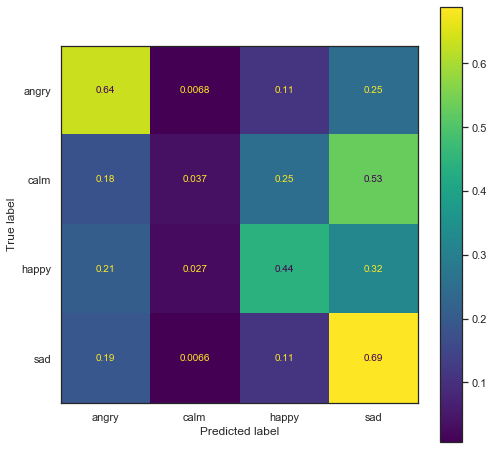

In [218]:
# Plot a confusion matrix to get classification errors
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plot_confusion_matrix(clf, X_test_idf, label_test, normalize='true', ax=ax)

# Build Classifier Model Using Lyrical Training Set (Lyrical Sentiment and Spotify Features)

In [ ]:
# Read in complete dataset
df_ds = pd.read_csv('Total_Spotify_4Emotion_AllParts.csv')

# Get lyrics for each song in the training dataset
df_ds = df_ds.dropna()
df_ds = df_ds.drop_duplicates(['artist', 'title'])

# Create a linear loudness variable by converting from decibels to gain
df_ds['loudness_linear'] = 10**(df_ds['loudness']/20.)

# Read from pre-compiled lyrics data
comb_lyrics = pd.read_csv('GeniusLyrics_VocalsOnlySet_FullFinal.csv')
comb_lyrics = comb_lyrics.dropna()
comb_lyrics = comb_lyrics.drop_duplicates(['artist', 'title'])

# Merge lyrics dataframe with Last.fm dataframe to obtain emotion labels
df_ds = df_ds.drop_duplicates(['artist', 'title'])
df_lyrics = pd.merge(df_ds, comb_lyrics, how='inner', on=['artist', 'title'])
df_lyrics


In [295]:
# Score sentiment of each song's lyrics
sent_scores = get_sentiment_scores(df_lyrics.lyrics)
len(sent_scores)


Getting sentiment for lyric #0...
Getting sentiment for lyric #100...
Getting sentiment for lyric #200...
Getting sentiment for lyric #300...
Getting sentiment for lyric #400...
Getting sentiment for lyric #500...
Getting sentiment for lyric #600...
Getting sentiment for lyric #700...
Getting sentiment for lyric #800...
Getting sentiment for lyric #900...
Getting sentiment for lyric #1000...
Getting sentiment for lyric #1100...
Getting sentiment for lyric #1200...
Getting sentiment for lyric #1300...
Getting sentiment for lyric #1400...
Getting sentiment for lyric #1500...
Getting sentiment for lyric #1600...
Getting sentiment for lyric #1700...
Getting sentiment for lyric #1800...
Getting sentiment for lyric #1900...
Getting sentiment for lyric #2000...
Getting sentiment for lyric #2100...
Getting sentiment for lyric #2200...
Getting sentiment for lyric #2300...
Getting sentiment for lyric #2400...
Getting sentiment for lyric #2500...
Getting sentiment for lyric #2600...
Getting senti

9071

In [296]:
# Grab actual sentiment values
#sents = [sent.polarity for sent in sent_scores]
df_lyrics['sent_score'] = sent_scores


In [403]:
# Write full training set (with lyrics and sentiment scores) to file
#df_lyrics.to_csv('GeniusLyrics_VocalsOnlySet_FullFinal_withSentScores.csv')

# Read in full training set (with lyrics and sentiment scores)
df_lyrics = pd.read_csv('GeniusLyrics_VocalsOnlySet_FullFinal_withSentScores.csv', index_col=0)
df_lyrics


,track_id,artist,title,happy_tags,num_happy_tags,calm_tags,num_calm_tags,sad_tags,num_sad_tags,angry_tags,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,loudness_linear,lyrics,sent_score
0,TRMRZAS128F92F2645,Teena Marie,Square Biz,['fun'],1,[],0,[],0,[],...,0.148000,0.000197,0.500,0.723,113.621,383707.0,4.0,0.422717,"Hee...\nEverybody get up\n\nFlash back, who's ...",0.9989
1,TRBLCSZ128F149F2AB,Patrick Wolf,Accident & Emergency,"['happy', 'my joy']",2,[],0,[],0,[],...,0.064100,0.073900,0.139,0.301,110.014,195467.0,4.0,0.540381,So come on\nGive me the worst and then again\n...,-0.9938
2,TROEQQD128F92E4B39,Jonathan Coulton,You Ruined Everything,['happy'],1,[],0,[],0,[],...,0.712000,0.000000,0.126,0.339,129.810,138267.0,4.0,0.240104,"I was fine, I pulled myself together\nJust in ...",0.9752
3,TRFNVAR128F92CFEA3,Lush,Ladykillers,"['fun', 'happy', 'happy wednesdays']",3,[],0,[],0,[],...,0.007170,0.000000,0.118,0.796,157.726,194160.0,4.0,0.476047,"Here we go, I'm hanging out in Camden\nDrinkin...",0.9951
4,TRSMGTL128F4288E7C,Stephen Lynch,Craig,['fun'],1,[],0,[],0,[],...,0.582000,0.000014,0.673,0.278,139.308,213573.0,4.0,0.464943,Everyone knows Jesus. The man who healed the l...,0.9815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9066,TRVKJMI128F1490EBA,Saliva,Doperide,[],0,[],0,[],0,"['aggressive', 'angry white boy polka']",...,0.000323,0.088900,0.407,0.705,190.016,206667.0,4.0,0.658188,Coming down like a hatchet\nRollin' with the m...,-0.2023
9067,TRVKXQQ128F423EAF0,Kristin Hersh,Teeth,[],0,[],0,[],0,['violent'],...,0.867000,0.000000,0.107,0.312,150.713,250107.0,3.0,0.227117,I could get a piece of meat\nFrom a barren tre...,-0.9294
9068,TRVKRKH128F426503B,Fugees,Nappy Heads,[],0,[],0,[],0,['aggressive alternative rap'],...,0.137000,0.000069,0.109,0.642,97.109,322067.0,4.0,0.157997,Why am I trapped in a cage?\n(THE NAPPY HEADS ...,-0.9987
9069,TRVQFXO128F422DE75,Nada Surf,Treading Water,[],0,[],0,[],0,['aggressive'],...,0.001540,0.000000,0.117,0.355,157.816,263067.0,4.0,0.519338,Movies like zoos\nTry another me and I will tr...,0.7351


In [405]:
#plt.scatter(df_lyrics[df_lyrics.overall_emotion == 'happy'].sent_score.values, df_lyrics[df_lyrics.overall_emotion == 'happy'].valence.values)
#plt.scatter(df_lyrics[df_lyrics.overall_emotion == 'angry'].sent_score.values, df_lyrics[df_lyrics.overall_emotion == 'angry'].valence.values, c='r')

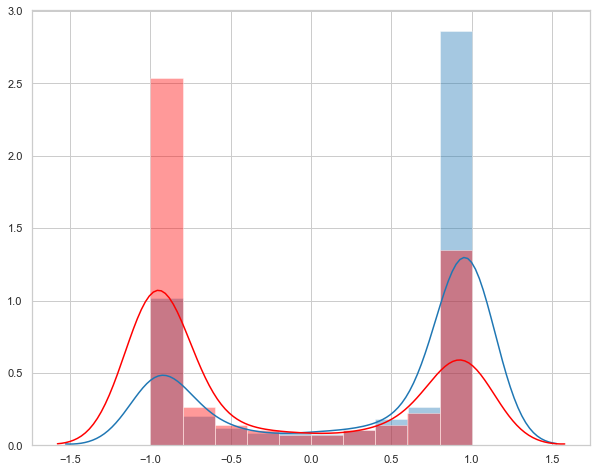

In [314]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(df_lyrics[df_lyrics.overall_emotion == 'happy'].sent_score.values, bins=10, ax=ax)
sns.distplot(df_lyrics[df_lyrics.overall_emotion == 'angry'].sent_score.values, color='r', bins=10, ax=ax)


In [411]:
# Reduce the lyrics training set to only include 'happy', 'sad', and 'angry'
df_lyrics_red = df_lyrics[df_lyrics.overall_emotion != 'calm']

# Input features
features = df_lyrics_red[['sent_score', 'danceability', 'energy', 'key', 'loudness_linear', 
            'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'duration_ms', 'mode', 'time_signature']]

# Output labels for emotion classification
labels = df_lyrics_red[['overall_emotion']]

# Create training/testing split
#x_train, x_test, y_train, y_test = split_by_emotion(features, labels)
x_train, x_test, y_train, y_test = train_test_split(features, labels)
print("Using a training dataset of size:", len(x_train))
print("Using a test dataset of size:", len(x_test))


Using a training dataset of size: 5454
Using a test dataset of size: 1819


In [412]:
# Do recursive feature elimination with 5-fold cross validation
# to determine which parameters to include
selector = RFECV(RandomForestClassifier(), cv=5)
selector = selector.fit(x_train, y_train.values.ravel())

In [413]:
x_train.columns[selector.support_]

Index(['sent_score', 'danceability', 'energy', 'key', 'loudness_linear',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'mode', 'time_signature'],
      dtype='object')

In [414]:
x_train.columns

Index(['sent_score', 'danceability', 'energy', 'key', 'loudness_linear',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'mode', 'time_signature'],
      dtype='object')

In [415]:
# Set up pipeline for a logistic regression model
clf_pipe = Pipeline([
                    ('scale', StandardScaler()),
                    ('clf', LogisticRegression(random_state=1))
                    ])

parameters = {'clf__penalty' : ['l1', 'l2'],
              'clf__C' : np.logspace(-4, 4, 20),
              'clf__solver' : ['liblinear', 'saga']
}

gs_clf = GridSearchCV(clf_pipe, parameters, cv=5)
gs_clf.fit(x_train, y_train.values.ravel())
print(f'Mean CV score of best estimator: {gs_clf.best_score_}')
gs_clf.best_params_


/Users/jecutter/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jecutter/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jecutter/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jecutter/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jecutter/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:3

Mean CV score of best estimator: 0.676386111554924


{'clf__C': 1.623776739188721, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

Test accuracy of 66.68499175371083 %
Best averaged CV accuracy was 67.6386111554924 %


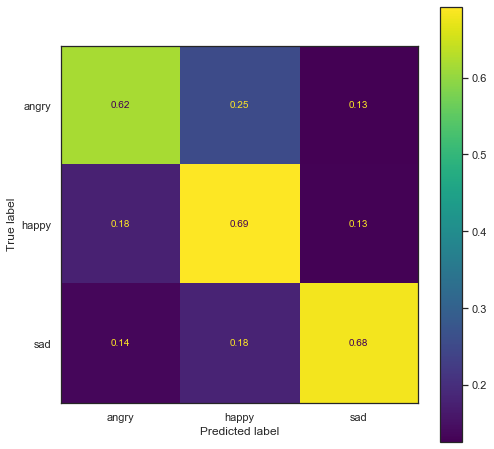

In [416]:
# Run the model on the test data
y_pred = gs_clf.best_estimator_.predict(x_test)
print("Test accuracy of", np.sum(y_test['overall_emotion'].values==y_pred)*100./(len(y_pred)*1.), "%")
print('Best averaged CV accuracy was', gs_clf.best_score_*100., '%')

# Plot a confusion matrix to get classification errors
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plot_confusion_matrix(gs_clf.best_estimator_, x_test, y_test, normalize='true', ax=ax)


In [417]:
# Set up pipeline for a stochastic gradient descent (SGD) model
# Use default "hinge" loss (SVM)
clf_pipe = Pipeline([
                    ('scale', StandardScaler()),
                    ('clf', SGDClassifier(random_state=1))
                    ])

parameters = {'clf__penalty' : ['l1', 'l2'],
              'clf__alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]
             }

gs_clf = GridSearchCV(clf_pipe, parameters, cv=5)
gs_clf.fit(x_train, y_train.values.ravel())
print(f'Mean CV score of best estimator: {gs_clf.best_score_}')
gs_clf.best_params_


Mean CV score of best estimator: 0.6723522733961772


{'clf__alpha': 0.01, 'clf__penalty': 'l2'}

Test accuracy of 66.52006597031335 %
Best averaged CV accuracy was 67.23522733961772 %


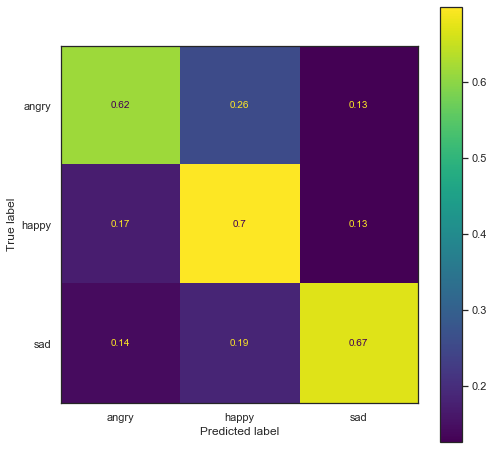

In [418]:
# Run the model on the test data
y_pred = gs_clf.best_estimator_.predict(x_test)
print("Test accuracy of", np.sum(y_test['overall_emotion'].values==y_pred)*100./(len(y_pred)*1.), "%")
print('Best averaged CV accuracy was', gs_clf.best_score_*100., '%')

# Plot a confusion matrix to get classification errors
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plot_confusion_matrix(gs_clf.best_estimator_, x_test, y_test, normalize='true', ax=ax)


In [419]:
# Set up pipeline for a Random Forest model
clf_pipe = Pipeline([
                    ('scale', StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=1))
                    ])

parameters = {'clf__n_estimators' : [500, 1000, 2000, 3000],
              'clf__max_depth' : [5, 15, 30],
              'clf__min_samples_split' : [2, 5],
              'clf__min_samples_leaf' : [1, 3]
             }

gs_clf = GridSearchCV(clf_pipe, parameters, cv=5)
gs_clf.fit(x_train, y_train.values.ravel())
print(f'Mean CV score of best estimator: {gs_clf.best_score_}')
gs_clf.best_params_


Mean CV score of best estimator: 0.6862856229870753


{'clf__max_depth': 15,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 5,
 'clf__n_estimators': 500}

Test accuracy of 68.11434854315559 %
Best averaged CV accuracy was 68.62856229870754 %


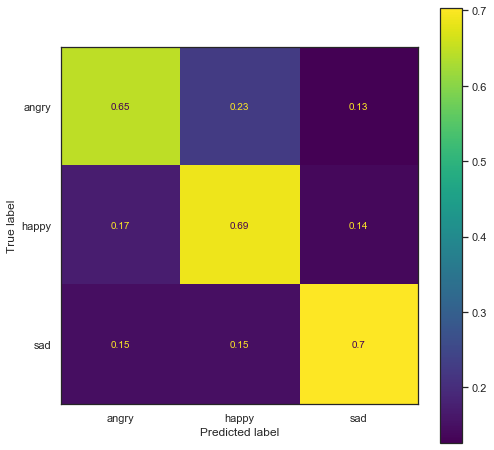

In [420]:
# Run the model on the test data
y_pred = gs_clf.best_estimator_.predict(x_test)
print("Test accuracy of", np.sum(y_test['overall_emotion'].values==y_pred)*100./(len(y_pred)*1.), "%")
print('Best averaged CV accuracy was', gs_clf.best_score_*100., '%')

# Plot a confusion matrix to get classification errors
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plot_confusion_matrix(gs_clf.best_estimator_, x_test, y_test, normalize='true', ax=ax)


<-- Feature importance -->
valence : 0.15181101503927194
energy : 0.12982024486673513
speechiness : 0.12491825972827118
acousticness : 0.09801878464415578
sent_score : 0.08958942566790076
danceability : 0.07898415754817835
duration_ms : 0.06542771552278952
loudness_linear : 0.06284844861795108
tempo : 0.057081972131209684
liveness : 0.05128543132933342
instrumentalness : 0.04614585803067578
key : 0.02917107573032784
mode : 0.00841933204284804
time_signature : 0.00647827910035148


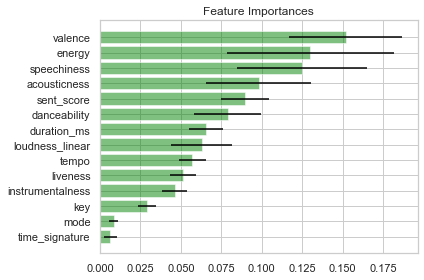

In [421]:
rfc = gs_clf.best_estimator_['clf']

# Show feature importances (sorted)
idx = sorted(range(len(rfc.feature_importances_)), key=lambda k: rfc.feature_importances_[k], reverse=True)
#for i,f in enumerate(features):
print('<-- Feature importance -->')
for i in idx:
    print(features.columns[i], ':', rfc.feature_importances_[i])

# Sort features by importance (not reversed) for bar plotting
idx = sorted(range(len(rfc.feature_importances_)), key=lambda k: rfc.feature_importances_[k])
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

# Create horizontal bar plot breaking down feature importances,
# with errors derived from standard deviation of all tree estimators in forest
y_axis = range(features.shape[1])
fig = plt.figure()
plt.title("Feature Importances")
plt.barh(y_axis, importances[idx], color="g", xerr=std[idx], align="center", alpha=0.5)
plt.yticks(y_axis, features.columns[idx])
plt.tight_layout()

In [343]:
# Pickle model and write to a file for app use
#pickle.dump(gs_clf.best_estimator_, open('best_lyrical_pipeline.pkl', 'wb'))
#dump(gs_clf.best_estimator_, 'best_lyrical_pipeline.joblib')

['best_lyrical_pipeline.joblib']

# Build Classifier Model Using Instrumental Training Set (Spotify Features Only)

In [386]:
# Read in complete dataset
df_ds = pd.read_csv('Total_Spotify_4Emotion_AllParts.csv')

# Get lyrics for each song in the training dataset
df_ds = df_ds.dropna()
df_ds = df_ds.drop_duplicates(['artist', 'title'])

# Create a linear loudness variable by converting from decibels to gain
df_ds['loudness_linear'] = 10**(df_ds['loudness']/20.)

# Isolate instrumental music
df_inst = df_ds[(df_ds['instrumentalness'] > 0.45) & (df_ds['speechiness'] < 0.33)]
df_inst


,track_id,artist,title,happy_tags,num_happy_tags,calm_tags,num_calm_tags,sad_tags,num_sad_tags,angry_tags,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,loudness_linear
3,TRWQIHV128F930E3CA,Tiga,Beep Beep Beep,['happy'],1,[],0,[],0,[],...,1.0,0.0376,0.039400,0.837,0.0839,0.756,127.978,229760.0,4.0,0.609467
8,TRLBZEF128EF342DD0,The Ordinary Boys,I Luv U,"['happy', 'happiness music']",2,[],0,[],0,[],...,1.0,0.0329,0.390000,0.987,0.0815,0.494,136.088,189769.0,4.0,0.205944
11,TRRBLER128F9307689,Wonderland Avenue,White Horse,['happy'],1,[],0,[],0,[],...,0.0,0.0883,0.000798,0.723,0.0717,0.949,127.011,462080.0,4.0,0.428154
13,TRHIRPB128F426708A,Fairmont,Flight of the Albatross,['happy minimal for the morning'],1,[],0,[],0,[],...,1.0,0.0885,0.215000,0.918,0.0955,0.594,187.428,426267.0,3.0,0.338844
18,TRSNORX12903CDA834,ILS,Cherish,['happy breaks'],1,[],0,[],0,[],...,0.0,0.0286,0.001210,0.540,0.0829,0.458,135.899,283720.0,4.0,0.397741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16978,TRVKEKT128F932F7D5,Deep Purple,Wring That Neck,[],0,[],0,[],0,['violence'],...,0.0,0.0695,0.110000,0.906,0.4300,0.523,143.400,313667.0,4.0,0.333196
16979,TRVKZWR128F426AA9E,Meshuggah,Disenchantment,[],0,[],0,[],0,['aggressive bpm metal'],...,1.0,0.0959,0.000007,0.638,0.8200,0.156,48.724,104040.0,4.0,0.505475
16981,TRVKVQO128F4267B78,Tiesto,Flight 643 (Paul B + Subwave Remix),[],0,[],0,[],0,['aggressive'],...,0.0,0.0578,0.000167,0.759,0.2050,0.203,89.039,291880.0,4.0,0.452376
16983,TRVQJTS128F92EDA1F,Coughs,Photo Safari,[],0,[],0,[],0,['sexual frustration'],...,1.0,0.0873,0.088800,0.813,0.4380,0.768,119.813,167440.0,4.0,0.554690


In [393]:
# Reduce the lyrics training set to only include 'happy', 'sad', and 'angry'
df_inst_red = df_inst[df_inst.overall_emotion != 'calm']

# Input features
features = df_inst_red[['danceability', 'energy', 'key', 'loudness_linear', 
            'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'duration_ms', 'mode', 'time_signature']]

# Output labels for emotion classification
labels = df_inst_red[['overall_emotion']]

# Create training/testing split
x_train, x_test, y_train, y_test = train_test_split(features, labels)
print("Using a training dataset of size:", len(x_train))
print("Using a test dataset of size:", len(x_test))

Using a training dataset of size: 1419
Using a test dataset of size: 473


In [394]:
# Do recursive feature elimination with 5-fold cross validation
# to determine which parameters to include
selector = RFECV(RandomForestClassifier(), cv=5)
selector = selector.fit(x_train, y_train.values.ravel())

In [395]:
x_train.columns[selector.support_]

Index(['danceability', 'energy', 'key', 'loudness_linear', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

In [396]:
x_train.columns

Index(['danceability', 'energy', 'key', 'loudness_linear', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'mode', 'time_signature'],
      dtype='object')

In [397]:
# Input features
features = df_inst_red[['danceability', 'energy', 'loudness_linear', 'speechiness',
       'acousticness', 'instrumentalness', 'valence', 'tempo', 'duration_ms']]

# Output labels for emotion classification
labels = df_inst_red[['overall_emotion']]

# Create training/testing split
x_train, x_test, y_train, y_test = train_test_split(features, labels)
print("Using a training dataset of size:", len(x_train))
print("Using a test dataset of size:", len(x_test))


Using a training dataset of size: 1419
Using a test dataset of size: 473


/Users/jecutter/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jecutter/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jecutter/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jecutter/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jecutter/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:3

{'clf__C': 0.004832930238571752, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Test accuracy of 70.61310782241014 %
Mean CV score of best estimator: 64.83551485591997 %


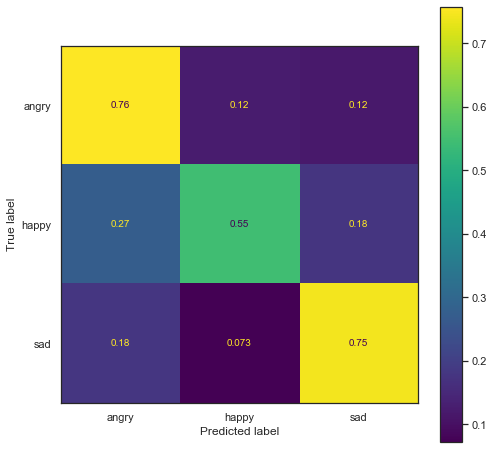

In [398]:
# Set up pipeline for a logistic regression model
clf_pipe = Pipeline([
                    ('scale', StandardScaler()),
                    ('clf', LogisticRegression(random_state=1))
                    ])

parameters = {'clf__penalty' : ['l1', 'l2'],
              'clf__C' : np.logspace(-4, 4, 20),
              'clf__solver' : ['liblinear', 'saga']
}

gs_clf = GridSearchCV(clf_pipe, parameters, cv=5)
gs_clf.fit(x_train, y_train.values.ravel())
#print(f'Mean CV score of best estimator: {gs_clf.best_score_}')
print(gs_clf.best_params_)

# Run the model on the test data
y_pred = gs_clf.best_estimator_.predict(x_test)
print("Test accuracy of", np.sum(y_test['overall_emotion'].values==y_pred)*100./(len(y_pred)*1.), "%")
print(f'Mean CV score of best estimator: {gs_clf.best_score_*100.}', '%')

# Plot a confusion matrix to get classification errors
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plot_confusion_matrix(gs_clf.best_estimator_, x_test, y_test, normalize='true', ax=ax)


{'clf__alpha': 0.01, 'clf__penalty': 'l2'}
Test accuracy of 70.19027484143763 %
Mean CV score of best estimator: 63.28522370974967 %


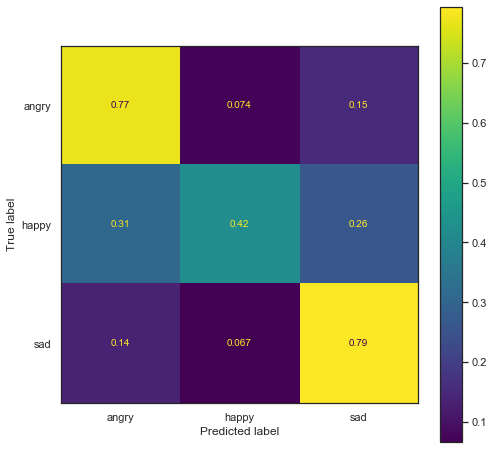

In [399]:
# Set up pipeline for a stochastic gradient descent (SGD) model
# Use default "hinge" loss (SVM)
clf_pipe = Pipeline([
                    ('scale', StandardScaler()),
                    ('clf', SGDClassifier(random_state=1))
                    ])

parameters = {'clf__penalty' : ['l1', 'l2'],
              'clf__alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]
             }

gs_clf = GridSearchCV(clf_pipe, parameters, cv=5)
gs_clf.fit(x_train, y_train.values.ravel())
#print(f'Mean CV score of best estimator: {gs_clf.best_score_}')
print(gs_clf.best_params_)

# Run the model on the test data
y_pred = gs_clf.best_estimator_.predict(x_test)
print("Test accuracy of", np.sum(y_test['overall_emotion'].values==y_pred)*100./(len(y_pred)*1.), "%")
print(f'Mean CV score of best estimator: {gs_clf.best_score_*100.}', '%')

# Plot a confusion matrix to get classification errors
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plot_confusion_matrix(gs_clf.best_estimator_, x_test, y_test, normalize='true', ax=ax)


{'clf__max_depth': 30, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 1000}
Test accuracy of 69.55602536997885 %
Mean CV score of best estimator: 66.87801721992733 %
<-- Feature importance -->
energy : 0.15176832998865708
valence : 0.14062830254100717
speechiness : 0.1397146170972861
acousticness : 0.12346379982024987
danceability : 0.10127344468624021
duration_ms : 0.09301948692841458
loudness_linear : 0.09069770681236441
tempo : 0.08361982670526315
instrumentalness : 0.07581448542051737


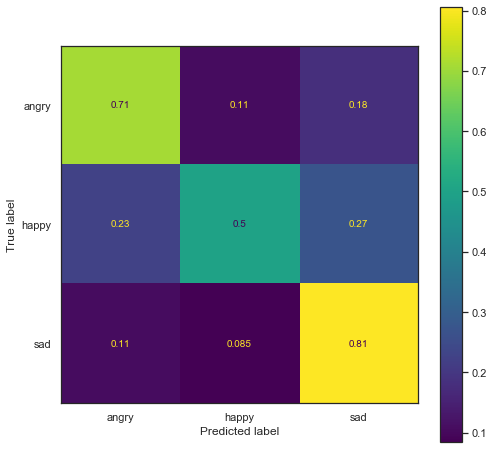

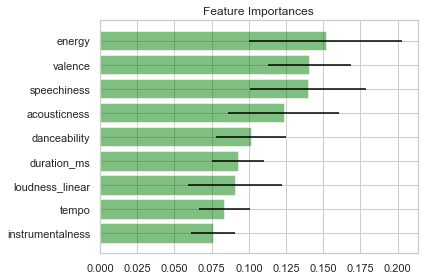

In [400]:
# Set up pipeline for a Random Forest model
clf_pipe = Pipeline([
                    ('scale', StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=1))
                    ])

parameters = {'clf__n_estimators' : [500, 1000, 2000, 3000],
              'clf__max_depth' : [5, 15, 30, 50],
              'clf__min_samples_split' : [2, 5],
              'clf__min_samples_leaf' : [1, 3]
             }

gs_clf = GridSearchCV(clf_pipe, parameters, cv=5)
gs_clf.fit(x_train, y_train.values.ravel())
#print(f'Mean CV score of best estimator: {gs_clf.best_score_}')
print(gs_clf.best_params_)

# Run the model on the test data
y_pred = gs_clf.best_estimator_.predict(x_test)
print("Test accuracy of", np.sum(y_test['overall_emotion'].values==y_pred)*100./(len(y_pred)*1.), "%")
print(f'Mean CV score of best estimator: {gs_clf.best_score_*100.}', '%')

# Plot a confusion matrix to get classification errors
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plot_confusion_matrix(gs_clf.best_estimator_, x_test, y_test, normalize='true', ax=ax)
    
    
# Grab RF model from best estimator (from GridSearch)
rfc = gs_clf.best_estimator_['clf']
    
# Show feature importances (sorted)
idx = sorted(range(len(rfc.feature_importances_)), key=lambda k: rfc.feature_importances_[k], reverse=True)
#for i,f in enumerate(features):
print('<-- Feature importance -->')
for i in idx:
    print(features.columns[i], ':', rfc.feature_importances_[i])

# Sort features by importance (not reversed) for bar plotting
idx = sorted(range(len(rfc.feature_importances_)), key=lambda k: rfc.feature_importances_[k])
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

# Create horizontal bar plot breaking down feature importances,
# with errors derived from standard deviation of all tree estimators in forest
y_axis = range(features.shape[1])
fig = plt.figure()
plt.title("Feature Importances")
plt.barh(y_axis, importances[idx], color="g", xerr=std[idx], align="center", alpha=0.5)
plt.yticks(y_axis, features.columns[idx])
plt.tight_layout()
